## 0 - Packages, setup, and helper functions

In [638]:
import os 
import time
import copy
import h5py
import glob
import scipy
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy.random import Generator, PCG64DXSM
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from scipy import ndimage
import math
import itertools
import torch
import torchvision as tv
import torchvision.transforms as transforms
# import torchvision.utils as utils
# from torch.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage import io, transform
import pylab as pl
from IPython import display
from copy import deepcopy
import optuna

# Using PCG64 as random generator
# Place seed [optional] for troubleshooting
rng = Generator(PCG64DXSM(seed=21))

# matplotlib general set up
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


Part 1: Dataset

In [639]:
class PillowDataset(Dataset):
    """CIFAR10 Subset of Two Classes dataset."""

    def __init__(self, data, targets, classes, transform=None):
        """
        Arguments:
            data (numpy array): CIFAR10 Dataset in numpy array
            targets (numpy array): Labels for samples in data
            keep_classes (numpy array): Index of classes to keep. This array is of length 2.
            classes: Two strings with the names of classes in keep_classes.
            transform (callable, optional): Optional transforms to be applied
                on a samples. This is applied during sampling (i.e., __getitem__())
        """
        self.data = data
        self.targets = targets
        self.transform = transform
        self.classes = classes


    def __len__(self):
        """
        Get the number of samples in dataset
        """
        return self.targets.shape[1]


    def __getitem__(self, idx):
        """
        Get a sample from the dataset
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.data[idx,...]
        target = self.targets[:, idx]
        sample = {'image': image, 'target': target}
        print(type(sample['image']))
        print(type(sample['target']))
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    
    def get_classes(self):
        """
        Returns string names for classes stored in this class.
        """
        return self.classes
    
    
    def class_to_idx(self, class_str):
        """
        Returns the index of the input class name.
        """
        try:
            index = self.classes.index(class_str)
        except ValueError:
            print(f"'{class_str}' is not in the list.")
            print(f"Your options are: <<{self.classes}>>.")
        return index
    

    def show_image(self, sample_idx, cmap):
        """
        Displays image at position sample_idx and its label.
        """
        
        image = self.data[sample_idx,...]
        label = self.targets[:, sample_idx]
        pl.cla()
        pl.imshow(image, cmap=cmap)
        pl.text(image.shape[1]*0.7, image.shape[0]*0.8, str(np.squeeze(label)), c='r')
        display.clear_output(wait=True)
        display.display(pl.gcf())


    def filter_dataset(self, data, targets, keepLabels):
        """
            Generate a new list of images and binary targets from original dataset.
        """
    
        # Throw error if keepLabels is not length 2
        assert len(keepLabels) == 2

        #ensure keepLabels and targets are numpy arrays
        keepLabels = np.array(keepLabels)
        targets = np.array(targets)

        # Get indexes of desired classes samples
        mask_idx = np.where(np.isin(targets, keepLabels))[0]
        print(mask_idx)
        
        # how many samples for keep classes do we have
        m = mask_idx.size
        print(f"M is {m}")
    
        #empty list of tensors
        self.data = np.ndarray(np.concatenate(([m], data.shape[1:])))
        self.targets = np.ndarray([1, m])
        print(mask_idx.shape)
        print(type(mask_idx))
        print(f"Shapes of data and targets: {self.data.shape}/{self.targets.shape}")
        for i in range(mask_idx.size):

            # save new image
            self.data[i,...] = np.copy(data[mask_idx[i],...])

            #create correct target
            if (targets[:,mask_idx[i]] == keepLabels[0]):
                self.targets[:,i] = 0
            else:
                self.targets[:,i] = 1

In [640]:
class FaceDataset(Dataset):
    """CIFAR10 Subset of Two Classes dataset."""

    def __init__(self, data, targets, classes, transform=None):
        """
        Arguments:
            data (numpy array): CIFAR10 Dataset in numpy array
            targets (numpy array): Labels for samples in data
            keep_classes (numpy array): Index of classes to keep. This array is of length 2.
            classes: Two strings with the names of classes in keep_classes.
            transform (callable, optional): Optional transforms to be applied
                on a samples. This is applied during sampling (i.e., __getitem__())
        """
        self.filter_dataset(data, targets, [0, 1])
        # self.data = data
        # self.targets = targets
        self.transform = transform
        self.classes = classes


    def __len__(self):
        """
        Get the number of samples in dataset
        """
        return self.targets.shape[1]


    def __getitem__(self, idx):
        """
        Get a sample from the dataset
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.data[idx,...]
        target = self.targets[:, idx]
        sample = {'image': image, 'target': target}
        print(type(sample['image']))
        print(type(sample['target']))
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    
    def get_classes(self):
        """
        Returns string names for classes stored in this class.
        """
        return self.classes
    
    
    def class_to_idx(self, class_str):
        """
        Returns the index of the input class name.
        """
        try:
            index = self.classes.index(class_str)
        except ValueError:
            print(f"'{class_str}' is not in the list.")
            print(f"Your options are: <<{self.classes}>>.")
        return index
    

    def show_image(self, sample_idx, cmap):
        """
        Displays image at position sample_idx and its label.
        """
        
        image = self.data[sample_idx,...]
        label = self.targets[:, sample_idx]
        pl.cla()
        pl.imshow(image, cmap=cmap)
        pl.text(image.shape[1]*0.7, image.shape[0]*0.8, str(np.squeeze(label)), c='r')
        display.clear_output(wait=True)
        display.display(pl.gcf())


    def filter_dataset(self, data, targets, keepLabels):
        """
            Generate a new list of images and binary targets from original dataset.
        """
    
        # Throw error if keepLabels is not length 2
        assert len(keepLabels) == 2

        #ensure keepLabels and targets are numpy arrays
        keepLabels = np.array(keepLabels)
        targets = np.array(targets)

        # Get indexes of desired classes samples
        mask_idx = np.where(np.isin(targets, keepLabels))[0]
        print(mask_idx)
        
        # how many samples for keep classes do we have
        m = mask_idx.size
        print(f"M is {m}")
    
        #empty list of tensors
        self.data = np.ndarray(np.concatenate(([m], data.shape[1:])))
        self.targets = np.ndarray([1, m])
        print(mask_idx.shape)
        print(type(mask_idx))
        print(f"Shapes of data and targets: {self.data.shape}/{self.targets.shape}")
        for i in range(mask_idx.size):

            # save new image
            self.data[i,...] = np.copy(data[mask_idx[i],...])

            #create correct target
            if (targets[:,mask_idx[i]] == keepLabels[0]):
                self.targets[:,i] = 0
            else:
                self.targets[:,i] = 1

In [641]:
data_path = "./data_real_binary"

trans = transforms.Compose([
  transforms.Resize([64,64]),  
  transforms.Grayscale(),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))])
batch_size = 16

In [650]:
data = tv.datasets.ImageFolder(root=data_path, transform=trans)
print(type(data))



splits = random_split(data, [0.3, 0.7])

print(len(splits[0]), len(splits[1]))
print(data.classes)

# trainloader = torch.utils.data.DataLoader(splits[1], batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testloader = torch.utils.data.DataLoader(splits[0], batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# for i, pain in enumerate(trainloader.dataset):
#     print(pain)

<class 'torchvision.datasets.folder.ImageFolder'>
11 25
['happiness', 'sadness']


In [643]:
# Define a batch size
batch_size = 1

# Create iterators for dataset
train_loader = torch.utils.data.DataLoader(dataset=splits[1], shuffle=True, num_workers=0,
                                           batch_size=batch_size, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=splits[0], shuffle=True, num_workers=0,
                                           batch_size=1, drop_last=True)
print(len(train_loader))
print(train_loader.dataset)
print(train_loader.dataset[2])


27
(tensor([[[-1., -1.,  1.,  ..., -1., -1., -1.],
         [-1., -1.,  1.,  ..., -1., -1., -1.],
         [-1., -1.,  1.,  ...,  1.,  1.,  1.],
         ...,
         [ 1.,  1.,  1.,  ...,  1., -1., -1.],
         [-1., -1., -1.,  ...,  1., -1., -1.],
         [-1., -1., -1.,  ...,  1., -1., -1.]]]), 0)


Part 2: Build 4-Layer Network

In [644]:
class NetWithoutDropout(nn.Module):

  # define network layers
  def __init__(self, layer_size):
    super().__init__()
    self.flatten = nn.Flatten(start_dim=1)
    self.fc1 = nn.Linear(layer_size[0], layer_size[1])
    self.ac1 = nn.ReLU()
    self.fc2 = nn.Linear(layer_size[1], layer_size[2])
    self.ac2 = nn.ReLU()
    self.fc3 = nn.Linear(layer_size[2], layer_size[3])
    self.ac3 = nn.ReLU()
    self.fc4 = nn.Linear(layer_size[3], layer_size[4])
    self.acL = nn.Sigmoid()


  # define forward pass
  def forward(self, x):

    #flatten images
    x = self.flatten(x)

    #hidden layers
    z1 = self.fc1(x)
    a1 = self.ac1(z1)
    z2 = self.fc2(a1)
    a2 = self.ac2(z2)
    z3 = self.fc3(a2)
    a3 = self.ac3(z3)

    #output layer
    z4 = self.fc4(a3)
    aL = self.acL(z4)

    #return model prediction
    return aL

#################################################
## Create network
model = NetWithoutDropout(layer_size=[20, 20, 10, 5, 1])
#Print model architecture
print(model)

NetWithoutDropout(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (ac1): ReLU()
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (ac2): ReLU()
  (fc3): Linear(in_features=10, out_features=5, bias=True)
  (ac3): ReLU()
  (fc4): Linear(in_features=5, out_features=1, bias=True)
  (acL): Sigmoid()
)


In [645]:
class ConvNetWithoutDropout(nn.Module):

  # define network layers
  def __init__(self):
    super().__init__()
    # 1 input image channel, 6 output channels, 5x5 square convolution
    # kernel
    self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
    self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(4096, 128)  # 5*5 from image dimension
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 1)


  # define forward pass
  def forward(self, x):
    # Max pooling over a (2, 2) window
    # print(x.shape)
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    # print(x.shape)
    # If the size is a square, you can specify with a single number
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    # print(x.shape)
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.sigmoid(self.fc3(x))
    return x

#################################################
## Create network
model = ConvNetWithoutDropout()
#Print model architecture
print(model)

ConvNetWithoutDropout(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [646]:
#################################################
# Weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.00)


# Initialize model weights and biases
model.apply(init_weights)

/tmp/ipykernel_8354/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


ConvNetWithoutDropout(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [647]:
# Functions to train and troubleshoot the model

def get_accuracy(net, data_loader):
  """It iterates over `data_loader` to calculate accuracy"""
  total_correct = 0.0
  total_samples = 0.0
  with torch.no_grad():
    for i_batch, sample_batched in enumerate(data_loader):
      # data and labels
      inputs, labels = sample_batched[0], sample_batched[1]
      labels = np.array(labels)
      outputs = np.array(net(inputs.float()))
      predictions = outputs.round()
      # calculate the accuracy for this batch
      total_correct += (predictions == labels).astype(float).sum().item()
      total_samples += predictions.shape[0]
  # calculate the accuracy
  return total_correct / total_samples

def get_val_loss(net, criterion, data_loader):
  """It iterates over `data_loader` to calculate the overall loss"""
  testing_loss = []
  with torch.no_grad():
    for i_batch, sample_batched in enumerate(data_loader):
      # data and labels
      inputs, labels = sample_batched[0], sample_batched[1]

     # inputs, labels = inputs.to(device), labels.to(device)
      outputs = net(inputs.float())
      # calculate the loss for this batch
      loss = criterion(outputs, torch.reshape(labels.float(), outputs.shape))
      # add the loss of this batch to the list
      testing_loss.append(loss.item())
  # calculate the average loss
  return sum(testing_loss) / len(testing_loss)

In [648]:
def train_model(train_loader, val_loader, model, criterion, optimizer, start_epoch=0, start_tr_loss=None, start_val_loss=None, 
                Num_Epochs=100, checkpoint_interval=50, run_name="default", save=False):
  """
  This routine receives a model architecture, a dataset with corresponding labels and other configurations for supervised training of model.

  Parameters:
    train_loader -- iterable object with data samples created using torch.utils.data.DataLoader.
    val_loader -- iterable object with validation samples created using torch.utils.data.DataLoader.
    model -- Valid Pytorch nn.Module network
    criterion -- Loss function from PyTorch nn library
    optimizer -- Optimization technique from PyTorch optim library
    Num_epochs -- Number of times to go through the train_loader samples
    start_epoch -- when resuming a previous run, this is the last epoch number performed.
    start_tr_loss -- when resuming previous run, it add the loss history to current train run
    start_val_loss -- same as with start_tr_loss but for validation set
    checkpoint_interval -- After how many epochs to save and printout network progress.
    run_name -- Prefix string used for checkpoint filename
    save -- when True it will save checkpoints 
  
  Returns:
    model -- final model with its parameters
    training_loss -- List with training loss for each epoch 
    val_loss -- List with validation loss for each epoch
  """

  if(start_tr_loss):
    training_loss, val_loss = start_tr_loss, start_val_loss
  else:
    training_loss, val_loss = [], []
  running_loss = []
  i = 0
  for epoch in range(start_epoch, Num_Epochs):
    for i_batch, sample_batched in enumerate(train_loader):

      # data and labels
      inputs, labels = sample_batched[0], sample_batched[1]

      # resets all gradients for this mini-batch
      optimizer.zero_grad()
      # print(inputs.shape)
      # forward pass
      outputs = model(inputs.float())
      # print(outputs)
      # print(labels)
      #Cost
      # print(outputs.shape)
      # print(torch.reshape(labels.float(), outputs.shape))
      loss = criterion(outputs, torch.reshape(labels.float(), outputs.shape))

      # backward pass
      loss.backward()

      # update parameters
      optimizer.step()

      # Save current loss for plots
      running_loss.append(loss.item())
      i += 1

    #track progress
    # print(running_loss)
    avg_train_loss = sum(running_loss) / len(running_loss)
    avg_val_loss = get_val_loss(model, criterion, val_loader)

    # clear the list
    running_loss.clear()

    #store loss
    training_loss.append(avg_train_loss)
    val_loss.append(avg_val_loss)

    #print loss per epoch
    if((epoch+1)%checkpoint_interval==0):
      if(save):
        torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'training_loss': training_loss,
          'validation_loss': val_loss,
        }, f'{run_name}_checkpoint_{epoch+1}.pt')
      print(f"[E={epoch:2d}] [it={i:5d}] Train Loss: {avg_train_loss:.3f}, Test Loss: {avg_val_loss:.3f}")

  #return model and losses from training
  return model, training_loss, val_loss


/tmp/ipykernel_8354/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E=19] [it=  540] Train Loss: 0.660, Test Loss: 0.586
[E=39] [it= 1080] Train Loss: 0.550, Test Loss: 0.618
[E=59] [it= 1620] Train Loss: 0.780, Test Loss: 0.744
[E=79] [it= 2160] Train Loss: 0.034, Test Loss: 1.916
[E=99] [it= 2700] Train Loss: 0.556, Test Loss: 0.917
[E=119] [it= 3240] Train Loss: 0.052, Test Loss: 2.687
[E=139] [it= 3780] Train Loss: 0.505, Test Loss: 0.592
[E=159] [it= 4320] Train Loss: 0.212, Test Loss: 0.938
[E=179] [it= 4860] Train Loss: 0.068, Test Loss: 1.590
[E=199] [it= 5400] Train Loss: 0.069, Test Loss: 0.870
Accuracy: Train: 1.000 | Val: 0.667


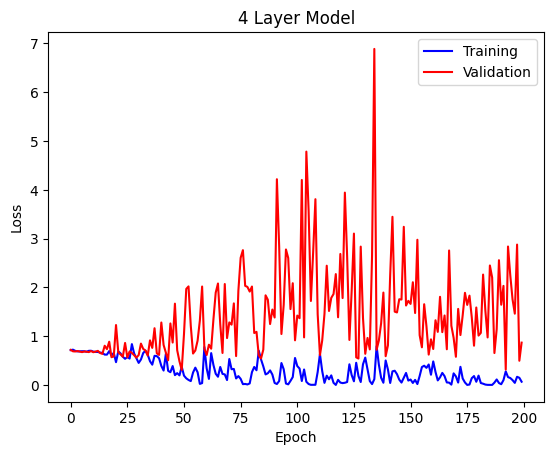

In [651]:
run_name = "sgd"
# How many epochs before saving progress
checkpoint_interval = 20
# Learning rate
learning_rate = 0.005
# L2 Normalization lambda
weight_decay = 0.01
# Momentum
momentum = 0.9
# Nesterov?
nesterov = False

# With a batch size of 64, need 198 epochs to get to 2,000 iterations
Num_Epochs = 200

# Compute input size
# sample = (next(iter(train_loader)))[0]
# input_size = np.prod(sample.shape[1:])


#################################################
# Create network architecture
model = ConvNetWithoutDropout()

# Initialize model weights
model.apply(init_weights)

## Loss, and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)


#################################################
# Train model

model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                           criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)

tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
val_acc = get_accuracy(net=model_final, data_loader=val_loader)
print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )

plt.figure()
plt.plot(trainloss, '-b')
plt.plot(valloss, '-r')
plt.ioff()
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"])
plt.title(f"4 Layer Model")
plt.show()

Part 3: Regularization

In [652]:
# Run name
run_name = "sgd_w_mom"

##############################################
# Hyperparameters and training configuration

# How many epochs before saving progress
checkpoint_interval = 20
# Learning rate
learning_rate = 0.0005
# L2 Normalization lambda
weight_decays = [0, 0.001, 0.01, 0.1]
# Momentum
momentum = 0.9
# Nesterov?
nesterov = False
#Number of epochs
Num_Epochs = 200


# Define layer sizes
#layer_size = [input_size, 2*input_size, input_size, input_size//2, 1]
trainlosses = []
vallosses = []
for weight_decay in weight_decays:
    #################################################
    # Create network architecture
    #model = NetUsingSequential(layer_size=layer_size)
    model = ConvNetWithoutDropout()
    #model = NetWithDropout(layer_size=layer_size)

    # Initialize model weights
    model.apply(init_weights)

    ## Loss, and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)


    #################################################
    # Train model
    model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                            criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)

    # Output model performance
    tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
    val_acc = get_accuracy(net=model_final, data_loader=val_loader)
    print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )
    trainlosses.append(trainloss)
    vallosses.append(valloss)

# # Save final model
# torch.save({
#         'model_state_dict': model_final.state_dict(),
#         'training_accuracy': tr_acc,
#         'validation_accuracy': val_acc,
#       }, f'{run_name}_final.pt')

/tmp/ipykernel_8354/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E=19] [it=  540] Train Loss: 0.493, Test Loss: 0.626
[E=39] [it= 1080] Train Loss: 0.433, Test Loss: 0.823
[E=59] [it= 1620] Train Loss: 0.139, Test Loss: 0.836
[E=79] [it= 2160] Train Loss: 0.211, Test Loss: 0.938
[E=99] [it= 2700] Train Loss: 0.011, Test Loss: 1.661
[E=119] [it= 3240] Train Loss: 0.002, Test Loss: 1.959
[E=139] [it= 3780] Train Loss: 0.002, Test Loss: 1.258
[E=159] [it= 4320] Train Loss: 0.001, Test Loss: 2.063
[E=179] [it= 4860] Train Loss: 0.001, Test Loss: 1.560
[E=199] [it= 5400] Train Loss: 0.001, Test Loss: 1.736
Accuracy: Train: 1.000 | Val: 0.444
[E=19] [it=  540] Train Loss: 0.628, Test Loss: 0.671
[E=39] [it= 1080] Train Loss: 0.190, Test Loss: 0.762
[E=59] [it= 1620] Train Loss: 0.028, Test Loss: 1.881
[E=79] [it= 2160] Train Loss: 0.005, Test Loss: 2.340
[E=99] [it= 2700] Train Loss: 0.002, Test Loss: 1.962
[E=119] [it= 3240] Train Loss: 0.003, Test Loss: 0.920
[E=139] [it= 3780] Train Loss: 0.001, Test Loss: 2.355
[E=159] [it= 4320] Train Loss: 0.001, T

/tmp/ipykernel_8354/1423120969.py:9: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend("Training", "Validation")


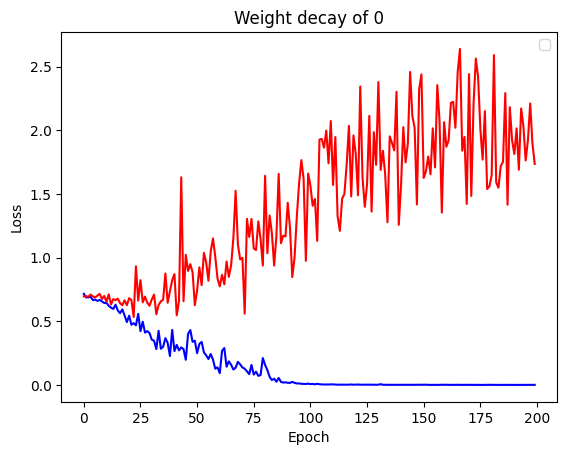

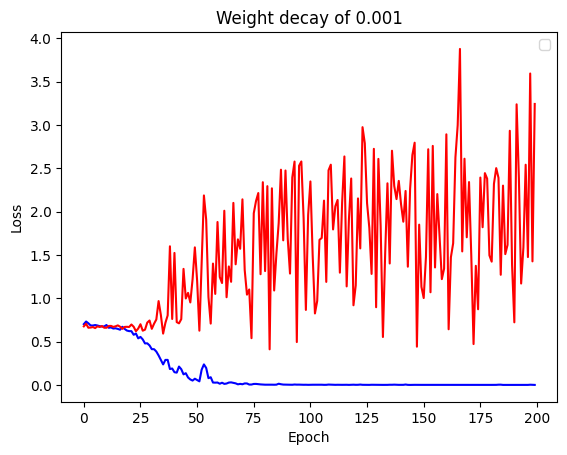

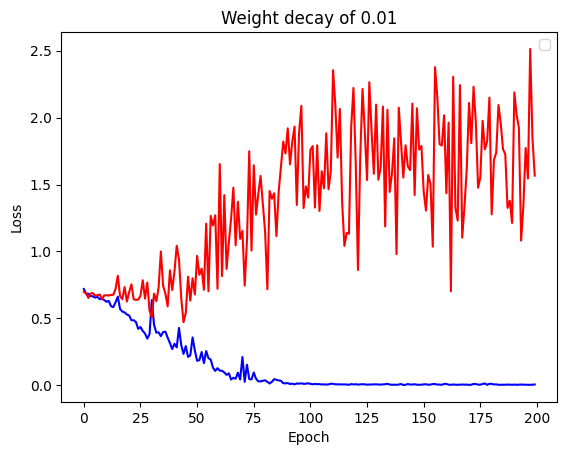

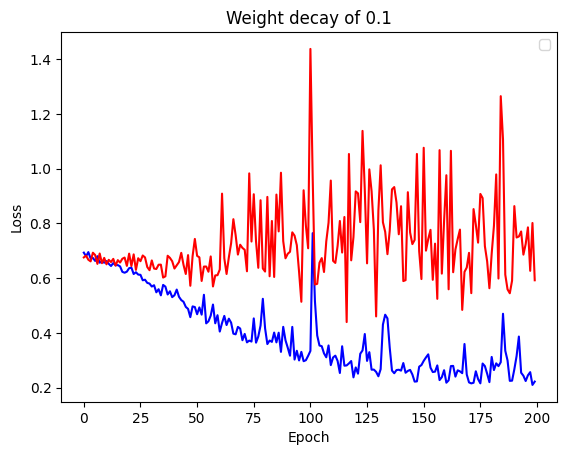

In [653]:
for trainloss, valloss, decay in zip(trainlosses, vallosses, weight_decays):
# Plot training and validation loss
    plt.figure()
    plt.plot(trainloss, '-b')
    plt.plot(valloss, '-r')
    plt.ioff()
    plt.ylabel('Loss')
    plt.xlabel("Epoch")
    plt.legend("Training", "Validation")
    plt.title(f"Weight decay of {decay}")
    plt.show()

Part 4: Optimization

SGD with momentum

In [654]:
##############################################
# Hyperparameters and training configuration

# How many epochs before saving progress
checkpoint_interval = 20
# Learning rate
learning_rate = 0.0005
# L2 Normalization lambda
weight_decay = 0.01
# Momentum
momentum = 0.9
# Nesterov?
nesterov = False
#Number of epochs
Num_Epochs = 200

In [655]:
# How many epochs before saving progress
checkpoint_interval = 20
# Learning rate
learning_rate = 0.005
# L2 Normalization lambda
weight_decay = 0.01
# Momentum
momentum = 0.9
# Nesterov?
nesterov = False

# With a batch size of 64, need 198 epochs to get to 2,000 iterations
Num_Epochs = 198

# # Compute input size
# sample = (next(iter(train_loader)))["image"]
# input_size = np.prod(sample.shape[1:])


#################################################
# Create network architecture
model = ConvNetWithoutDropout()

# Initialize model weights
model.apply(init_weights)

## Loss, and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)


#################################################
# Train model

model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                           criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)

tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
val_acc = get_accuracy(net=model_final, data_loader=val_loader)
print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )

/tmp/ipykernel_8354/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E=19] [it=  540] Train Loss: 0.638, Test Loss: 0.568
[E=39] [it= 1080] Train Loss: 0.016, Test Loss: 1.106
[E=59] [it= 1620] Train Loss: 0.064, Test Loss: 0.288
[E=79] [it= 2160] Train Loss: 0.390, Test Loss: 0.138
[E=99] [it= 2700] Train Loss: 0.234, Test Loss: 1.166
[E=119] [it= 3240] Train Loss: 0.321, Test Loss: 0.316
[E=139] [it= 3780] Train Loss: 0.007, Test Loss: 0.400
[E=159] [it= 4320] Train Loss: 0.003, Test Loss: 1.049
[E=179] [it= 4860] Train Loss: 0.697, Test Loss: 0.679
Accuracy: Train: 0.519 | Val: 0.667


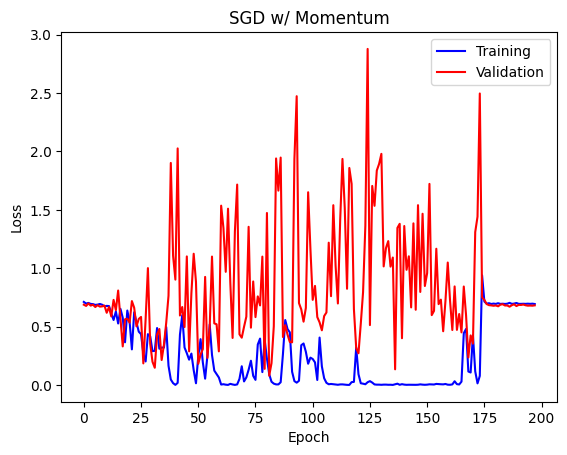

In [656]:
plt.figure()
plt.plot(trainloss, '-b')
plt.plot(valloss, '-r')
plt.ioff()
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"])
plt.title(f"SGD w/ Momentum")
plt.show()

Nesterov

In [657]:
nesterov = True

In [658]:
# # Compute input size
# sample = (next(iter(train_loader)))[0]
# input_size = np.prod(sample.shape[1:])


#################################################
# Create network architecture
model = ConvNetWithoutDropout()

# Initialize model weights
model.apply(init_weights)

## Loss, and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)


#################################################
# Train model

model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                           criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)
tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
val_acc = get_accuracy(net=model_final, data_loader=val_loader)
print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )

/tmp/ipykernel_8354/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E=19] [it=  540] Train Loss: 0.393, Test Loss: 1.010
[E=39] [it= 1080] Train Loss: 0.556, Test Loss: 0.627
[E=59] [it= 1620] Train Loss: 0.549, Test Loss: 0.705
[E=79] [it= 2160] Train Loss: 0.233, Test Loss: 1.071
[E=99] [it= 2700] Train Loss: 0.202, Test Loss: 0.406
[E=119] [it= 3240] Train Loss: 0.200, Test Loss: 1.102
[E=139] [it= 3780] Train Loss: 0.270, Test Loss: 1.206
[E=159] [it= 4320] Train Loss: 0.363, Test Loss: 0.862
[E=179] [it= 4860] Train Loss: 0.547, Test Loss: 0.550
Accuracy: Train: 0.852 | Val: 0.556


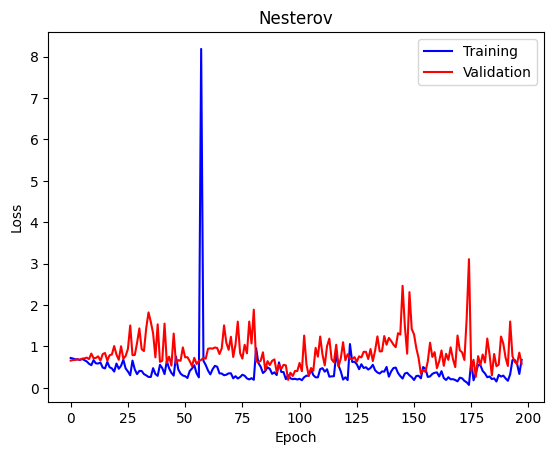

In [659]:
plt.figure()
plt.plot(trainloss, '-b')
plt.plot(valloss, '-r')
plt.ioff()
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"])
plt.title(f"Nesterov")
plt.show()

ADAM

In [660]:
# betas = (0.92, 1.5e-5)
betas = (0.0583756, 0.0003968)
# checkpoint_interval = 20
# learning_rate = 0.00592
# weight_decay = 0.09363750831559917
# momentum = 0.9
# nesterov = False
# How many epochs before saving progress
checkpoint_interval = 20
# Learning rate
learning_rate = 0.04325696
# L2 Normalization lambda
weight_decay = 0.03090098
# Momentum
momentum = 0.9
# Nesterov?
nesterov = False

train_loader = torch.utils.data.DataLoader(dataset=splits[1], shuffle=True, num_workers=0,
                                           batch_size=2, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=splits[0], shuffle=True, num_workers=0,
                                           batch_size=1, drop_last=True)

In [661]:
# # Compute input size
# sample = (next(iter(train_loader)))[0]
# input_size = np.prod(sample.shape[1:])


#################################################
# Create network architecture
model = ConvNetWithoutDropout()

# Initialize model weights
model.apply(init_weights)

## Loss, and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=betas)


#################################################
# Train model

model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                           criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)
tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
val_acc = get_accuracy(net=model_final, data_loader=val_loader)
print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )

/tmp/ipykernel_8354/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E=19] [it=  240] Train Loss: 5.449, Test Loss: 0.690
[E=39] [it=  480] Train Loss: 25.558, Test Loss: 6.850
[E=59] [it=  720] Train Loss: 31.678, Test Loss: 54.545
[E=79] [it=  960] Train Loss: 22.681, Test Loss: 3.599
[E=99] [it= 1200] Train Loss: 18.863, Test Loss: 46.615
[E=119] [it= 1440] Train Loss: 16.721, Test Loss: 0.714
[E=139] [it= 1680] Train Loss: 6.043, Test Loss: 0.699
[E=159] [it= 1920] Train Loss: 17.618, Test Loss: 54.545
[E=179] [it= 2160] Train Loss: 4.936, Test Loss: 46.264
Accuracy: Train: 1.250 | Val: 0.455


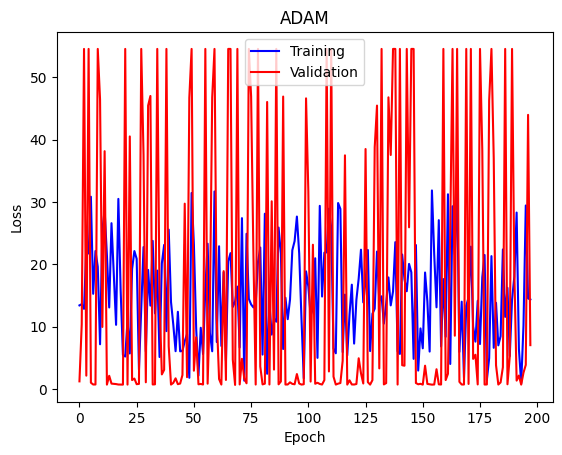

In [662]:
plt.figure()
plt.plot(trainloss, '-b')
plt.plot(valloss, '-r')
plt.ioff()
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"])
plt.title(f"ADAM")
plt.show()

NADAM

In [663]:
# # Compute input size
# sample = (next(iter(train_loader)))["image"]
# input_size = np.prod(sample.shape[1:])


#################################################
# Create network architecture
model = ConvNetWithoutDropout()

# Initialize model weights
model.apply(init_weights)

## Loss, and optimizer
criterion = nn.BCELoss()
optimizer = optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=betas)


#################################################
# Train model

model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                           criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)
tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
val_acc = get_accuracy(net=model_final, data_loader=val_loader)
print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )

/tmp/ipykernel_8354/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E=19] [it=  240] Train Loss: 18.437, Test Loss: 0.694
[E=39] [it=  480] Train Loss: 4.706, Test Loss: 0.695
[E=59] [it=  720] Train Loss: 5.110, Test Loss: 0.691
[E=79] [it=  960] Train Loss: 13.441, Test Loss: 0.789
[E=99] [it= 1200] Train Loss: 5.086, Test Loss: 0.747
[E=119] [it= 1440] Train Loss: 4.815, Test Loss: 0.693
[E=139] [it= 1680] Train Loss: 4.816, Test Loss: 0.693
[E=159] [it= 1920] Train Loss: 1.419, Test Loss: 0.711
[E=179] [it= 2160] Train Loss: 4.824, Test Loss: 0.706
Accuracy: Train: 0.750 | Val: 0.545


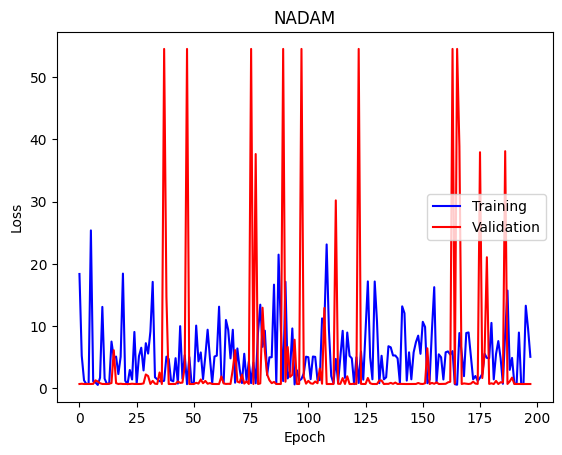

In [664]:
plt.figure()
plt.plot(trainloss, '-b')
plt.plot(valloss, '-r')
plt.ioff()
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"])
plt.title(f"NADAM")
plt.show()

Part 4: Dropout Masks

In [667]:
class ConvNetWithDropout(nn.Module):

  # define network layers
  def __init__(self):
    super().__init__()
    # 1 input image channel, 6 output channels, 5x5 square convolution
    # kernel
    self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
    self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(4096, 128)  # 5*5 from image dimension
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 1)

    self.dc2 = nn.Dropout(0.5)
    self.dc3 = nn.Dropout(0.5)


  # define forward pass
  def forward(self, x):
    # Max pooling over a (2, 2) window
    # print(x.shape)
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    # print(x.shape)
    # If the size is a square, you can specify with a single number
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    # print(x.shape)
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = self.dc2(F.relu(self.fc1(x)))
    x = self.dc3(F.relu(self.fc2(x)))
    x = F.sigmoid(self.fc3(x))
    return x
    return x

#################################################
## Create network
model = ConvNetWithoutDropout()
#Print model architecture
print(model)

ConvNetWithoutDropout(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


/tmp/ipykernel_8354/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E=19] [it=  240] Train Loss: 0.677, Test Loss: 0.757
[E=39] [it=  480] Train Loss: 0.581, Test Loss: 0.706
[E=59] [it=  720] Train Loss: 0.629, Test Loss: 0.710
[E=79] [it=  960] Train Loss: 0.732, Test Loss: 0.828
[E=99] [it= 1200] Train Loss: 0.251, Test Loss: 1.294
[E=119] [it= 1440] Train Loss: 0.430, Test Loss: 0.814
[E=139] [it= 1680] Train Loss: 0.385, Test Loss: 1.145
[E=159] [it= 1920] Train Loss: 0.367, Test Loss: 1.336
[E=179] [it= 2160] Train Loss: 0.603, Test Loss: 0.741
[E=199] [it= 2400] Train Loss: 0.146, Test Loss: 2.261
Accuracy: Train: 1.500 | Val: 0.455


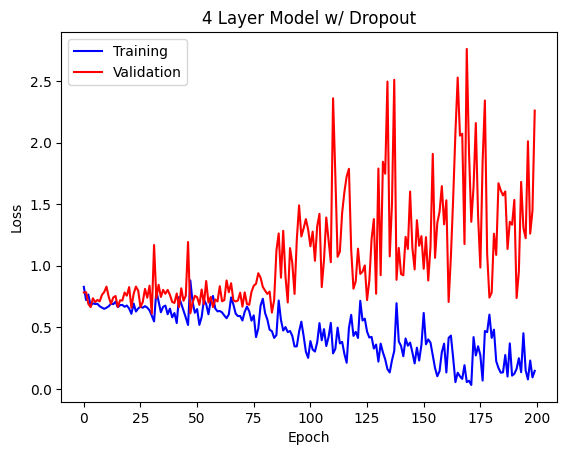

In [669]:
run_name = "sgd"
# How many epochs before saving progress
checkpoint_interval = 20
# Learning rate
learning_rate = 0.005
# L2 Normalization lambda
weight_decay = 0.01
# Momentum
momentum = 0.9
# Nesterov?
nesterov = False

# With a batch size of 64, need 198 epochs to get to 2,000 iterations
Num_Epochs = 200

# # Compute input size
# sample = (next(iter(train_loader)))["image"]
# input_size = np.prod(sample.shape[1:])


#################################################
# Create network architecture
model = ConvNetWithDropout()

# Initialize model weights
model.apply(init_weights)

## Loss, and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)


#################################################
# Train model

model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model, save=False,
                                           criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)

tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
val_acc = get_accuracy(net=model_final, data_loader=val_loader)
print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )

plt.figure()
plt.plot(trainloss, '-b')
plt.plot(valloss, '-r')
plt.ioff()
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"])
plt.title(f"4 Layer Model w/ Dropout")
plt.show()

In [672]:
def objective_SGD(trial):

    # Trial configuration
    # Name for run
    run_name = "Optuna-Test"
    # How many epochs before saving progress
    checkpoint_interval = 50
    #Number of epochs
    Num_Epochs = 100
    ## Loss
    criterion = nn.BCELoss()

    ##############################################
    # Hyperparameters search spaces
    # Learning rate
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    # L2 Normalization lambda
    weight_decay = trial.suggest_float("L2", 1e-5, 1e-1, log=True)
    # Batch size
    batch_size = trial.suggest_categorical("batch_size", [1, 2, 4, 8])
    momentum = 0.9
    nesterov = trial.suggest_categorical("nesterov", [True, False])
    # Adam beta values
    # adam_betas = (1.0-trial.suggest_float("beta1", 0.05, 0.15, log=True), 1.0-trial.suggest_float("beta2", 1e-5, 1e-3, log=True))
    

    #################################################
    # Generate data loader based on new batch size
    train_loader = torch.utils.data.DataLoader(dataset=splits[1], shuffle=True, num_workers=0,
                                           batch_size=batch_size, drop_last=True)
    val_loader = torch.utils.data.DataLoader(dataset=splits[0], shuffle=True, num_workers=0,
                                           batch_size=1, drop_last=True)

    #################################################
    # Create network architecture
    # Compute input size
    # sample = (next(iter(train_loader)))[0]
    # input_size = np.prod(sample.shape[1:])
    # layer_size = [input_size, np.power(2,10), np.power(2,9), np.power(2,8), np.power(2,0)]
    #model = NetUsingSequential(layer_size=layer_size)
    model = ConvNetWithoutDropout()
    #model = NetWithDropout(layer_size=layer_size)

    # Initialize model weights
    model.apply(init_weights)

    ## Optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=adam_betas)

    
    #################################################
    # Train model
    model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model,
                                            criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)

    # Output model performance
    #tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
    
    tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
    val_acc = get_accuracy(net=model_final, data_loader=val_loader)
    print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )
    #print(f"{run_name}: Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )
    
    # The objective function needs to return the metric to minimize or maximize
    return val_acc

study = optuna.create_study(direction="maximize", study_name="Adam-CIFAR-Binary")
study.optimize(objective_SGD, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-04-09 22:47:34,402] A new study created in memory with name: Adam-CIFAR-Binary
/tmp/ipykernel_8354/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E=49] [it=  600] Train Loss: 0.452, Test Loss: 0.838


[I 2024-04-09 22:47:53,739] Trial 0 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00022362468276652906, 'L2': 7.551193907322501e-05, 'batch_size': 2, 'nesterov': True}. Best is trial 0 with value: 0.45454545454545453.


[E=99] [it= 1200] Train Loss: 0.338, Test Loss: 1.042
Accuracy: Train: 1.333 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.573, Test Loss: 0.748


[I 2024-04-09 22:48:12,848] Trial 1 finished with value: 0.5454545454545454 and parameters: {'lr': 0.00012615144912081467, 'L2': 0.0002870162343836473, 'batch_size': 2, 'nesterov': True}. Best is trial 1 with value: 0.5454545454545454.


[E=99] [it= 1200] Train Loss: 0.425, Test Loss: 0.810
Accuracy: Train: 1.333 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.000, Test Loss: 2.157


[I 2024-04-09 22:48:38,094] Trial 2 finished with value: 0.6363636363636364 and parameters: {'lr': 0.0024783905249765753, 'L2': 0.0001546493685323955, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.000, Test Loss: 2.569
Accuracy: Train: 1.000 | Val: 0.636
[E=49] [it=  600] Train Loss: 0.681, Test Loss: 0.716


[I 2024-04-09 22:48:56,552] Trial 3 finished with value: 0.45454545454545453 and parameters: {'lr': 0.009068932556899525, 'L2': 0.07726057266522712, 'batch_size': 2, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.671, Test Loss: 0.713
Accuracy: Train: 1.250 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.603, Test Loss: 0.722


[I 2024-04-09 22:49:22,448] Trial 4 finished with value: 0.5454545454545454 and parameters: {'lr': 6.576383119228663e-05, 'L2': 0.009468525636318254, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.493, Test Loss: 0.705
Accuracy: Train: 0.840 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.009, Test Loss: 1.794


[I 2024-04-09 22:49:36,294] Trial 5 finished with value: 0.6363636363636364 and parameters: {'lr': 0.018098125520954255, 'L2': 0.00018090486073894495, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.305, Test Loss: 2.640
Accuracy: Train: 4.750 | Val: 0.636
[E=49] [it=  300] Train Loss: 0.492, Test Loss: 0.782


[I 2024-04-09 22:49:51,919] Trial 6 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0007071785479302073, 'L2': 0.00032267098099904106, 'batch_size': 4, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  600] Train Loss: 0.112, Test Loss: 1.272
Accuracy: Train: 2.667 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.175, Test Loss: 1.311


[I 2024-04-09 22:50:10,960] Trial 7 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0008099598641318327, 'L2': 0.004868197086369559, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.007, Test Loss: 2.022
Accuracy: Train: 1.417 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.664, Test Loss: 0.748


[I 2024-04-09 22:50:24,357] Trial 8 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0002368156996039595, 'L2': 0.014927434044882273, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.628, Test Loss: 0.760
Accuracy: Train: 4.667 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.159, Test Loss: 1.076


[I 2024-04-09 22:50:42,806] Trial 9 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0010725318524808655, 'L2': 3.253956261715676e-05, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.005, Test Loss: 2.171
Accuracy: Train: 1.500 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.669, Test Loss: 0.714
[E=99] [it= 2500] Train Loss: 0.661, Test Loss: 0.731


[I 2024-04-09 22:51:05,841] Trial 10 finished with value: 0.45454545454545453 and parameters: {'lr': 1.2603320016918673e-05, 'L2': 0.0012567346131699278, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.666, Test Loss: 0.712


[I 2024-04-09 22:51:19,349] Trial 11 finished with value: 0.45454545454545453 and parameters: {'lr': 0.06706625451037707, 'L2': 1.0811668599206844e-05, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.342, Test Loss: 1.811
Accuracy: Train: 4.417 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.667, Test Loss: 0.739


[I 2024-04-09 22:51:42,869] Trial 12 finished with value: 0.45454545454545453 and parameters: {'lr': 0.009871507370566218, 'L2': 0.00014704137495154536, 'batch_size': 1, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.730, Test Loss: 0.725
Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.004, Test Loss: 2.252


[I 2024-04-09 22:51:56,164] Trial 13 finished with value: 0.2727272727272727 and parameters: {'lr': 0.00766472351945236, 'L2': 0.0008994238546170515, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.001, Test Loss: 3.012
Accuracy: Train: 4.250 | Val: 0.273
[E=49] [it=  300] Train Loss: 13.537, Test Loss: 0.699


[I 2024-04-09 22:52:11,263] Trial 14 finished with value: 0.45454545454545453 and parameters: {'lr': 0.04995887907838543, 'L2': 3.967848446880394e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  600] Train Loss: 0.684, Test Loss: 0.739
Accuracy: Train: 2.333 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.328, Test Loss: 1.604


[I 2024-04-09 22:52:24,285] Trial 15 finished with value: 0.36363636363636365 and parameters: {'lr': 0.0034258232878023437, 'L2': 0.001024975499188699, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.004, Test Loss: 1.672
Accuracy: Train: 4.333 | Val: 0.364
[E=49] [it= 1250] Train Loss: 0.702, Test Loss: 0.714
[E=99] [it= 2500] Train Loss: 0.686, Test Loss: 0.745


[I 2024-04-09 22:52:49,007] Trial 16 finished with value: 0.45454545454545453 and parameters: {'lr': 0.02001907031181038, 'L2': 1.6878205206416614e-05, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.014, Test Loss: 1.901


[I 2024-04-09 22:53:12,523] Trial 17 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0025531023702061936, 'L2': 0.0001364197012439276, 'batch_size': 1, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.000, Test Loss: 2.501
Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.295, Test Loss: 1.123


[I 2024-04-09 22:53:25,173] Trial 18 finished with value: 0.5454545454545454 and parameters: {'lr': 0.024132571150270316, 'L2': 0.0005292528535902109, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.038, Test Loss: 1.681
Accuracy: Train: 4.417 | Val: 0.545
[E=49] [it=  300] Train Loss: 0.030, Test Loss: 1.841


[I 2024-04-09 22:53:39,638] Trial 19 finished with value: 0.36363636363636365 and parameters: {'lr': 0.002646068202417495, 'L2': 0.002996182116395022, 'batch_size': 4, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  600] Train Loss: 0.004, Test Loss: 2.441
Accuracy: Train: 2.583 | Val: 0.364
[E=49] [it= 1250] Train Loss: 0.689, Test Loss: 0.764


[I 2024-04-09 22:53:59,946] Trial 20 finished with value: 0.45454545454545453 and parameters: {'lr': 0.030048980206139834, 'L2': 8.150105093809607e-05, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.682, Test Loss: 0.750
Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.657, Test Loss: 0.731


[I 2024-04-09 22:54:16,526] Trial 21 finished with value: 0.45454545454545453 and parameters: {'lr': 5.469089103189422e-05, 'L2': 0.00026083045093001667, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.641, Test Loss: 0.749
Accuracy: Train: 1.167 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.630, Test Loss: 0.752


[I 2024-04-09 22:54:29,106] Trial 22 finished with value: 0.6363636363636364 and parameters: {'lr': 0.0003003427029120679, 'L2': 0.0002617889017034557, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.533, Test Loss: 0.781
Accuracy: Train: 4.167 | Val: 0.636
[E=49] [it=  150] Train Loss: 0.560, Test Loss: 0.769


[I 2024-04-09 22:54:41,648] Trial 23 finished with value: 0.5454545454545454 and parameters: {'lr': 0.001447401281834773, 'L2': 6.799218509498557e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.193, Test Loss: 1.294
Accuracy: Train: 4.750 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.653, Test Loss: 0.725


[I 2024-04-09 22:54:54,168] Trial 24 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00034772055060195914, 'L2': 0.0020857009323626873, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.615, Test Loss: 0.728
Accuracy: Train: 5.000 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.593, Test Loss: 0.695


[I 2024-04-09 22:55:06,566] Trial 25 finished with value: 0.45454545454545453 and parameters: {'lr': 0.09474888874017484, 'L2': 0.0004793004335040047, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.686, Test Loss: 0.732
Accuracy: Train: 4.667 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.016, Test Loss: 0.956


[I 2024-04-09 22:55:19,143] Trial 26 finished with value: 0.6363636363636364 and parameters: {'lr': 0.00538923388592303, 'L2': 0.00014719568629160978, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.001, Test Loss: 1.338
Accuracy: Train: 4.417 | Val: 0.636
[E=49] [it=  150] Train Loss: 0.049, Test Loss: 1.445


[I 2024-04-09 22:55:31,833] Trial 27 finished with value: 0.45454545454545453 and parameters: {'lr': 0.013972294257583236, 'L2': 2.9777349706723215e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.000, Test Loss: 2.487
Accuracy: Train: 4.417 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.119, Test Loss: 1.487
[E=99] [it= 2500] Train Loss: 0.005, Test Loss: 2.441


[I 2024-04-09 22:55:56,250] Trial 28 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00045841818327255673, 'L2': 0.0005776045635492738, 'batch_size': 1, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it=  300] Train Loss: 0.643, Test Loss: 0.721


[I 2024-04-09 22:56:12,670] Trial 29 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00015509128263785122, 'L2': 6.124989357536445e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  600] Train Loss: 0.638, Test Loss: 0.722
Accuracy: Train: 2.333 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.338, Test Loss: 1.091


[I 2024-04-09 22:56:26,047] Trial 30 finished with value: 0.36363636363636365 and parameters: {'lr': 0.0017402936015090181, 'L2': 0.0001868520574503738, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.041, Test Loss: 1.928
Accuracy: Train: 4.167 | Val: 0.364
[E=49] [it=  150] Train Loss: 0.328, Test Loss: 1.112


[I 2024-04-09 22:56:39,301] Trial 31 finished with value: 0.2727272727272727 and parameters: {'lr': 0.004165563048471495, 'L2': 0.0001105691335409168, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.014, Test Loss: 1.707
Accuracy: Train: 4.417 | Val: 0.273
[E=49] [it=  150] Train Loss: 0.148, Test Loss: 1.139


[I 2024-04-09 22:56:52,597] Trial 32 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0049621600894944416, 'L2': 0.0002469677192265287, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.003, Test Loss: 1.906
Accuracy: Train: 4.167 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.073, Test Loss: 2.039


[I 2024-04-09 22:57:05,965] Trial 33 finished with value: 0.36363636363636365 and parameters: {'lr': 0.006452086888287173, 'L2': 0.0004177734329022382, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.001, Test Loss: 2.271
Accuracy: Train: 4.333 | Val: 0.364
[E=49] [it=  150] Train Loss: 0.678, Test Loss: 0.697


[I 2024-04-09 22:57:19,346] Trial 34 finished with value: 0.45454545454545453 and parameters: {'lr': 7.706662070396012e-05, 'L2': 9.400690938240917e-05, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.678, Test Loss: 0.717
Accuracy: Train: 4.667 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.113, Test Loss: 1.292


[I 2024-04-09 22:57:42,174] Trial 35 finished with value: 0.36363636363636365 and parameters: {'lr': 0.0004493805062350946, 'L2': 0.00018639332552046817, 'batch_size': 1, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.003, Test Loss: 2.292
Accuracy: Train: 1.000 | Val: 0.364
[E=49] [it=  150] Train Loss: 0.298, Test Loss: 1.237


[I 2024-04-09 22:57:55,532] Trial 36 finished with value: 0.36363636363636365 and parameters: {'lr': 0.012599475231402268, 'L2': 0.0652109929792569, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.305, Test Loss: 1.706
Accuracy: Train: 4.333 | Val: 0.364
[E=49] [it=  600] Train Loss: 0.556, Test Loss: 0.976
[E=99] [it= 1200] Train Loss: 61.540, Test Loss: 45.455


[I 2024-04-09 22:58:13,912] Trial 37 finished with value: 0.5454545454545454 and parameters: {'lr': 0.042522662377209884, 'L2': 5.138587407316377e-05, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


Accuracy: Train: 0.833 | Val: 0.545
[E=49] [it=  300] Train Loss: 0.263, Test Loss: 1.027


[I 2024-04-09 22:58:29,342] Trial 38 finished with value: 0.36363636363636365 and parameters: {'lr': 0.0012081526061074861, 'L2': 0.0003238224284649782, 'batch_size': 4, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  600] Train Loss: 0.047, Test Loss: 2.206
Accuracy: Train: 2.500 | Val: 0.364
[E=49] [it= 1250] Train Loss: 0.620, Test Loss: 0.713


[I 2024-04-09 22:58:52,664] Trial 39 finished with value: 0.5454545454545454 and parameters: {'lr': 3.0658133519729334e-05, 'L2': 2.1996066714876337e-05, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.570, Test Loss: 0.771
Accuracy: Train: 0.880 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.196, Test Loss: 0.973


[I 2024-04-09 22:59:05,941] Trial 40 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0020449049238200944, 'L2': 0.0007335128200885362, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.010, Test Loss: 1.752
Accuracy: Train: 4.750 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.596, Test Loss: 0.757


[I 2024-04-09 22:59:24,263] Trial 41 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0001298106349461963, 'L2': 0.0002667516186134511, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.483, Test Loss: 0.854
Accuracy: Train: 1.250 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.417, Test Loss: 0.836


[I 2024-04-09 22:59:42,838] Trial 42 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0006838786317147546, 'L2': 0.00012577095805703744, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.013, Test Loss: 1.592
Accuracy: Train: 1.500 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.570, Test Loss: 0.727


[I 2024-04-09 23:00:01,216] Trial 43 finished with value: 0.5454545454545454 and parameters: {'lr': 0.00021148640767972978, 'L2': 0.0014295763685002526, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.349, Test Loss: 0.933
Accuracy: Train: 1.333 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.617, Test Loss: 0.721


[I 2024-04-09 23:00:19,742] Trial 44 finished with value: 0.5454545454545454 and parameters: {'lr': 0.00010025727737586543, 'L2': 0.0003826638366999688, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.514, Test Loss: 0.763
Accuracy: Train: 1.333 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.638, Test Loss: 0.737


[I 2024-04-09 23:00:37,988] Trial 45 finished with value: 0.45454545454545453 and parameters: {'lr': 4.0866491453934614e-05, 'L2': 0.0001580096081464991, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.618, Test Loss: 0.749
Accuracy: Train: 1.167 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.345, Test Loss: 0.899


[I 2024-04-09 23:01:00,995] Trial 46 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00026222951011902227, 'L2': 4.619947003271699e-05, 'batch_size': 1, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.060, Test Loss: 1.274
Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.589, Test Loss: 0.760


[I 2024-04-09 23:01:14,593] Trial 47 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0006981633475265723, 'L2': 0.00019673134948561234, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.381, Test Loss: 0.865
Accuracy: Train: 4.167 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.642, Test Loss: 0.744


[I 2024-04-09 23:01:27,685] Trial 48 finished with value: 0.45454545454545453 and parameters: {'lr': 2.1108799479456736e-05, 'L2': 0.006673096492010649, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.668, Test Loss: 0.773
Accuracy: Train: 4.667 | Val: 0.455
[E=49] [it=  300] Train Loss: 0.166, Test Loss: 1.058


[I 2024-04-09 23:01:43,281] Trial 49 finished with value: 0.45454545454545453 and parameters: {'lr': 0.006392495952336126, 'L2': 8.903768472748463e-05, 'batch_size': 4, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  600] Train Loss: 0.001, Test Loss: 1.954
Accuracy: Train: 2.583 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.688, Test Loss: 0.709
[E=99] [it= 2500] Train Loss: 0.690, Test Loss: 0.733


[I 2024-04-09 23:02:08,160] Trial 50 finished with value: 0.45454545454545453 and parameters: {'lr': 0.017717516634914256, 'L2': 0.001431210768210959, 'batch_size': 1, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.650, Test Loss: 0.733


[I 2024-04-09 23:02:33,630] Trial 51 finished with value: 0.45454545454545453 and parameters: {'lr': 6.976641694269869e-05, 'L2': 0.01354869271578976, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.627, Test Loss: 0.723
Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.650, Test Loss: 0.708


[I 2024-04-09 23:02:56,699] Trial 52 finished with value: 0.45454545454545453 and parameters: {'lr': 1.1074030888811487e-05, 'L2': 0.04545800840351032, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.648, Test Loss: 0.709
Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.513, Test Loss: 0.805


[I 2024-04-09 23:03:20,653] Trial 53 finished with value: 0.5454545454545454 and parameters: {'lr': 0.00016204389584834235, 'L2': 0.004402716084594408, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.275, Test Loss: 1.554
Accuracy: Train: 0.840 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.324, Test Loss: 1.478


[I 2024-04-09 23:03:43,672] Trial 54 finished with value: 0.45454545454545453 and parameters: {'lr': 0.009694410906185752, 'L2': 0.0007455850574542062, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.680, Test Loss: 0.728
Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.671, Test Loss: 0.711


[I 2024-04-09 23:03:57,152] Trial 55 finished with value: 0.45454545454545453 and parameters: {'lr': 2.3686026531926965e-05, 'L2': 0.028427752974356256, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.671, Test Loss: 0.708
Accuracy: Train: 4.667 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.061, Test Loss: 1.215


[I 2024-04-09 23:04:15,826] Trial 56 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0009844242439201946, 'L2': 0.0002997787735530467, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.006, Test Loss: 1.736
Accuracy: Train: 1.417 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.001, Test Loss: 3.864
[E=99] [it= 2500] Train Loss: 0.000, Test Loss: 4.240


[I 2024-04-09 23:04:39,994] Trial 57 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0030746950428530376, 'L2': 0.0005743435195652501, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.643, Test Loss: 0.734


[I 2024-04-09 23:04:53,682] Trial 58 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0002980576491641693, 'L2': 0.002281737957365836, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.604, Test Loss: 0.747
Accuracy: Train: 4.917 | Val: 0.545
[E=49] [it=  150] Train Loss: 1.191, Test Loss: 1.263


[I 2024-04-09 23:05:07,087] Trial 59 finished with value: 0.5454545454545454 and parameters: {'lr': 0.03442655898062371, 'L2': 3.624092093658359e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.000, Test Loss: 2.664
Accuracy: Train: 4.333 | Val: 0.545
[E=49] [it=  300] Train Loss: 0.602, Test Loss: 0.762


[I 2024-04-09 23:05:22,798] Trial 60 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0004915472615160679, 'L2': 0.014684375980623613, 'batch_size': 4, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  600] Train Loss: 0.393, Test Loss: 0.820
Accuracy: Train: 2.500 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.416, Test Loss: 2.712


[I 2024-04-09 23:05:36,285] Trial 61 finished with value: 0.5454545454545454 and parameters: {'lr': 0.02459524706482996, 'L2': 0.0010391824810880566, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.000, Test Loss: 2.894
Accuracy: Train: 4.417 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.347, Test Loss: 1.548


[I 2024-04-09 23:05:49,697] Trial 62 finished with value: 0.45454545454545453 and parameters: {'lr': 0.06720733629935068, 'L2': 0.0004824856925777109, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.249, Test Loss: 2.520
Accuracy: Train: 4.167 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.012, Test Loss: 1.831


[I 2024-04-09 23:06:03,076] Trial 63 finished with value: 0.45454545454545453 and parameters: {'lr': 0.013064584903406168, 'L2': 0.0002035337471334331, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.053, Test Loss: 1.503
Accuracy: Train: 4.833 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.673, Test Loss: 0.722


[I 2024-04-09 23:06:16,564] Trial 64 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00010135776373266699, 'L2': 0.00012470688275697435, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.673, Test Loss: 0.727
Accuracy: Train: 4.667 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.128, Test Loss: 1.170


[I 2024-04-09 23:06:29,992] Trial 65 finished with value: 0.45454545454545453 and parameters: {'lr': 0.004237438721844505, 'L2': 8.212660516952604e-05, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.003, Test Loss: 2.481
Accuracy: Train: 4.750 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.708, Test Loss: 0.739
[E=99] [it= 2500] Train Loss: 0.688, Test Loss: 0.725


[I 2024-04-09 23:06:54,500] Trial 66 finished with value: 0.45454545454545453 and parameters: {'lr': 0.021033898751251796, 'L2': 0.00024142159133535876, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.390, Test Loss: 0.871


[I 2024-04-09 23:07:07,945] Trial 67 finished with value: 0.36363636363636365 and parameters: {'lr': 0.0021860299013420543, 'L2': 0.00037063070366807633, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.161, Test Loss: 0.935
Accuracy: Train: 4.417 | Val: 0.364
[E=49] [it=  600] Train Loss: 0.646, Test Loss: 0.723


[I 2024-04-09 23:07:26,665] Trial 68 finished with value: 0.45454545454545453 and parameters: {'lr': 5.378733361084078e-05, 'L2': 0.0001504019488276561, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.644, Test Loss: 0.707
Accuracy: Train: 1.167 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.215, Test Loss: 0.906


[I 2024-04-09 23:07:40,200] Trial 69 finished with value: 0.36363636363636365 and parameters: {'lr': 0.005797644645456208, 'L2': 6.184287154109626e-05, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.002, Test Loss: 2.134
Accuracy: Train: 5.417 | Val: 0.364
[E=49] [it= 1250] Train Loss: 0.676, Test Loss: 0.738


[I 2024-04-09 23:08:02,646] Trial 70 finished with value: 0.45454545454545453 and parameters: {'lr': 0.008447683768973637, 'L2': 0.0006531238573844402, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.689, Test Loss: 0.725
Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.547, Test Loss: 0.746


[I 2024-04-09 23:08:16,152] Trial 71 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0013020334356308972, 'L2': 6.812068443709133e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.201, Test Loss: 1.009
Accuracy: Train: 4.333 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.216, Test Loss: 1.301


[I 2024-04-09 23:08:29,565] Trial 72 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0034727996649402963, 'L2': 0.00010044534562765171, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.004, Test Loss: 2.089
Accuracy: Train: 4.500 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.461, Test Loss: 0.804


[I 2024-04-09 23:08:43,069] Trial 73 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0013261821082363983, 'L2': 1.3341350396509315e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.106, Test Loss: 1.342
Accuracy: Train: 4.167 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.313, Test Loss: 1.088


[I 2024-04-09 23:08:56,417] Trial 74 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0018369288547350744, 'L2': 2.7602443587216032e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.029, Test Loss: 2.280
Accuracy: Train: 4.500 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.656, Test Loss: 0.741


[I 2024-04-09 23:09:09,795] Trial 75 finished with value: 0.5454545454545454 and parameters: {'lr': 0.057925182899295255, 'L2': 0.00016243995736510384, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.254, Test Loss: 1.745
Accuracy: Train: 4.750 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.251, Test Loss: 1.632


[I 2024-04-09 23:09:28,263] Trial 76 finished with value: 0.45454545454545453 and parameters: {'lr': 0.015565333718666908, 'L2': 0.0004909464491144327, 'batch_size': 2, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.544, Test Loss: 0.791
Accuracy: Train: 1.250 | Val: 0.455
[E=49] [it=  300] Train Loss: 0.672, Test Loss: 0.739


[I 2024-04-09 23:09:44,021] Trial 77 finished with value: 0.36363636363636365 and parameters: {'lr': 0.03352676639560997, 'L2': 0.0002257807360295647, 'batch_size': 4, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  600] Train Loss: 0.563, Test Loss: 0.912
Accuracy: Train: 2.250 | Val: 0.364
[E=49] [it=  150] Train Loss: 0.675, Test Loss: 0.696


[I 2024-04-09 23:09:57,525] Trial 78 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00017650014738081687, 'L2': 0.00032048220531761764, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.661, Test Loss: 0.719
Accuracy: Train: 4.667 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.202, Test Loss: 1.534
[E=99] [it= 2500] Train Loss: 0.001, Test Loss: 2.312


[I 2024-04-09 23:10:20,716] Trial 79 finished with value: 0.45454545454545453 and parameters: {'lr': 0.001550895503702619, 'L2': 4.977846021618594e-05, 'batch_size': 1, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.659, Test Loss: 0.745


[I 2024-04-09 23:10:34,238] Trial 80 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00010988532002254438, 'L2': 0.00011340860052678486, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.651, Test Loss: 0.739
Accuracy: Train: 5.000 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.683, Test Loss: 0.723


[I 2024-04-09 23:10:52,956] Trial 81 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0408655849405295, 'L2': 5.267270804150704e-05, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.514, Test Loss: 1.541
Accuracy: Train: 1.333 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.705, Test Loss: 0.746


[I 2024-04-09 23:11:11,374] Trial 82 finished with value: 0.45454545454545453 and parameters: {'lr': 0.09421126189390147, 'L2': 2.3121724080614743e-05, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.668, Test Loss: 0.735
Accuracy: Train: 1.167 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.136, Test Loss: 1.246


[I 2024-04-09 23:11:29,890] Trial 83 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0008799582762053193, 'L2': 6.982366664025977e-05, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.005, Test Loss: 2.130
Accuracy: Train: 1.500 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.676, Test Loss: 0.745


[I 2024-04-09 23:11:48,598] Trial 84 finished with value: 0.45454545454545453 and parameters: {'lr': 0.04813012443394009, 'L2': 0.00015842951334930534, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.678, Test Loss: 0.748
Accuracy: Train: 1.167 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.680, Test Loss: 0.720


[I 2024-04-09 23:12:07,049] Trial 85 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0116229876206936, 'L2': 0.09662096473352629, 'batch_size': 2, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.681, Test Loss: 0.717
Accuracy: Train: 1.250 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.689, Test Loss: 0.742


[I 2024-04-09 23:12:30,658] Trial 86 finished with value: 0.45454545454545453 and parameters: {'lr': 0.02510940561418535, 'L2': 0.00090320674956432, 'batch_size': 1, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.694, Test Loss: 0.745
Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.003, Test Loss: 2.514


[I 2024-04-09 23:12:49,152] Trial 87 finished with value: 0.45454545454545453 and parameters: {'lr': 0.002677969535261012, 'L2': 0.00026675799277225834, 'batch_size': 2, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.000, Test Loss: 2.833
Accuracy: Train: 1.500 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.647, Test Loss: 0.711


[I 2024-04-09 23:13:02,532] Trial 88 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0005502789618925287, 'L2': 0.00038789424350224437, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.604, Test Loss: 0.749
Accuracy: Train: 4.333 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.594, Test Loss: 0.752


[I 2024-04-09 23:13:25,469] Trial 89 finished with value: 0.5454545454545454 and parameters: {'lr': 7.655520858791791e-05, 'L2': 9.473950614445507e-05, 'batch_size': 1, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.430, Test Loss: 0.868
Accuracy: Train: 0.840 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.638, Test Loss: 0.722


[I 2024-04-09 23:13:38,843] Trial 90 finished with value: 0.6363636363636364 and parameters: {'lr': 0.00036270552252629963, 'L2': 4.374968185593888e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.620, Test Loss: 0.719
Accuracy: Train: 4.750 | Val: 0.636
[E=49] [it=  150] Train Loss: 0.602, Test Loss: 0.753


[I 2024-04-09 23:13:52,235] Trial 91 finished with value: 0.6363636363636364 and parameters: {'lr': 0.00031480431264382035, 'L2': 3.1201093383684705e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.489, Test Loss: 0.818
Accuracy: Train: 4.750 | Val: 0.636
[E=49] [it=  150] Train Loss: 0.662, Test Loss: 0.737


[I 2024-04-09 23:14:05,632] Trial 92 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00032336512970194476, 'L2': 3.7687978800832994e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.627, Test Loss: 0.741
Accuracy: Train: 4.667 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.604, Test Loss: 0.712


[I 2024-04-09 23:14:18,935] Trial 93 finished with value: 0.5454545454545454 and parameters: {'lr': 0.000572334821624567, 'L2': 1.5019876124398319e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.468, Test Loss: 0.791
Accuracy: Train: 4.417 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.656, Test Loss: 0.738


[I 2024-04-09 23:14:32,332] Trial 94 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0002066356080566208, 'L2': 0.008337061342480455, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.640, Test Loss: 0.736
Accuracy: Train: 4.667 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.652, Test Loss: 0.722


[I 2024-04-09 23:14:45,845] Trial 95 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00024185022775633286, 'L2': 2.0575907770360595e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.648, Test Loss: 0.717
Accuracy: Train: 4.667 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.650, Test Loss: 0.711


[I 2024-04-09 23:14:59,477] Trial 96 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00035197986350945826, 'L2': 2.8397914418482746e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.627, Test Loss: 0.702
Accuracy: Train: 4.583 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.643, Test Loss: 0.726


[I 2024-04-09 23:15:12,958] Trial 97 finished with value: 0.45454545454545453 and parameters: {'lr': 5.903806909070876e-05, 'L2': 0.0001912770977393169, 'batch_size': 8, 'nesterov': False}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.647, Test Loss: 0.727
Accuracy: Train: 4.667 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.618, Test Loss: 0.732


[I 2024-04-09 23:15:26,471] Trial 98 finished with value: 0.6363636363636364 and parameters: {'lr': 0.00040275692535439607, 'L2': 1.0190881055815667e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.595, Test Loss: 0.744
Accuracy: Train: 4.917 | Val: 0.636
[E=49] [it=  150] Train Loss: 0.655, Test Loss: 0.724


[I 2024-04-09 23:15:39,925] Trial 99 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0003816390031324591, 'L2': 1.0913616282369796e-05, 'batch_size': 8, 'nesterov': True}. Best is trial 2 with value: 0.6363636363636364.


[E=99] [it=  300] Train Loss: 0.648, Test Loss: 0.741
Accuracy: Train: 5.000 | Val: 0.455
Best trial:
 Value: 0.6363636363636364
 Params: 
    lr: 0.0024783905249765753
    L2: 0.0001546493685323955
    batch_size: 1
    nesterov: True


Part 5: Hyperparameter Tuning

In [673]:
def objective(trial):

    # Trial configuration
    # Name for run
    run_name = "Optuna-Test"
    # How many epochs before saving progress
    checkpoint_interval = 50
    #Number of epochs
    Num_Epochs = 100
    ## Loss
    criterion = nn.BCELoss()

    ##############################################
    # Hyperparameters search spaces
    # Learning rate
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    # L2 Normalization lambda
    weight_decay = trial.suggest_float("L2", 1e-5, 1e-1, log=True)
    # Batch size
    batch_size = trial.suggest_categorical("batch_size", [1, 2, 4, 8])
    # Adam beta values
    adam_betas = (1.0-trial.suggest_float("beta1", 0.05, 0.15, log=True), 1.0-trial.suggest_float("beta2", 1e-5, 1e-3, log=True))

    #################################################
    # Generate data loader based on new batch size
    train_loader = torch.utils.data.DataLoader(dataset=splits[1], shuffle=True, num_workers=0,
                                           batch_size=batch_size, drop_last=True)
    val_loader = torch.utils.data.DataLoader(dataset=splits[0], shuffle=True, num_workers=0,
                                           batch_size=1, drop_last=True)

    #################################################
    # Create network architecture
    # Compute input size
    # sample = (next(iter(train_loader)))[0]
    # input_size = np.prod(sample.shape[1:])
    # layer_size = [input_size, np.power(2,10), np.power(2,9), np.power(2,8), np.power(2,0)]
    #model = NetUsingSequential(layer_size=layer_size)
    model = ConvNetWithoutDropout()
    #model = NetWithDropout(layer_size=layer_size)

    # Initialize model weights
    model.apply(init_weights)

    ## Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=adam_betas)

    
    #################################################
    # Train model
    model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model,
                                            criterion=criterion, optimizer=optimizer, Num_Epochs=Num_Epochs, checkpoint_interval=checkpoint_interval, run_name=run_name)

    # Output model performance
    #tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
    
    tr_acc = get_accuracy(net=model_final, data_loader=train_loader)
    val_acc = get_accuracy(net=model_final, data_loader=val_loader)
    print(f"Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )
    #print(f"{run_name}: Accuracy: Train: {tr_acc:.3f} | Val: {val_acc:0.3f}" )
    
    # The objective function needs to return the metric to minimize or maximize
    return val_acc

study = optuna.create_study(direction="maximize", study_name="Adam-CIFAR-Binary")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-04-09 23:15:39,940] A new study created in memory with name: Adam-CIFAR-Binary
/tmp/ipykernel_8354/1099974826.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[E=49] [it= 1250] Train Loss: 0.429, Test Loss: 0.798


[I 2024-04-09 23:16:07,454] Trial 0 finished with value: 0.5454545454545454 and parameters: {'lr': 2.175958744248453e-05, 'L2': 5.455009972463228e-05, 'batch_size': 1, 'beta1': 0.10305922046208753, 'beta2': 3.3332230420498164e-05}. Best is trial 0 with value: 0.5454545454545454.


[E=99] [it= 2500] Train Loss: 0.178, Test Loss: 0.922
Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.005, Test Loss: 0.924


[I 2024-04-09 23:16:26,788] Trial 1 finished with value: 0.6363636363636364 and parameters: {'lr': 0.0007483332778208233, 'L2': 0.0012242042169193657, 'batch_size': 2, 'beta1': 0.0565866510015898, 'beta2': 1.0877100037613297e-05}. Best is trial 1 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.002, Test Loss: 1.106
Accuracy: Train: 1.417 | Val: 0.636
[E=49] [it=  600] Train Loss: 0.679, Test Loss: 0.721


[I 2024-04-09 23:16:49,089] Trial 2 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0053304358018978855, 'L2': 0.037750711849054125, 'batch_size': 2, 'beta1': 0.13094762618697298, 'beta2': 0.00010730208668615654}. Best is trial 1 with value: 0.6363636363636364.


[E=99] [it= 1200] Train Loss: 0.665, Test Loss: 0.724
Accuracy: Train: 1.250 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.011, Test Loss: 1.619


[I 2024-04-09 23:17:18,017] Trial 3 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00015487776661361402, 'L2': 6.826870944098747e-05, 'batch_size': 1, 'beta1': 0.08933787648522168, 'beta2': 9.86028874178462e-05}. Best is trial 1 with value: 0.6363636363636364.


[E=99] [it= 2500] Train Loss: 0.004, Test Loss: 1.661
Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it=  300] Train Loss: 0.007, Test Loss: 1.573


[I 2024-04-09 23:17:34,092] Trial 4 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0007009964671627148, 'L2': 4.067074776877594e-05, 'batch_size': 4, 'beta1': 0.1264908904263326, 'beta2': 0.00024866108611050724}. Best is trial 1 with value: 0.6363636363636364.


[E=99] [it=  600] Train Loss: 0.000, Test Loss: 2.054
Accuracy: Train: 2.333 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.560, Test Loss: 0.717


[I 2024-04-09 23:17:47,835] Trial 5 finished with value: 0.7272727272727273 and parameters: {'lr': 4.3687538798590254e-05, 'L2': 0.010815536714479237, 'batch_size': 8, 'beta1': 0.12772908706997058, 'beta2': 4.1653864234181367e-05}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it=  300] Train Loss: 0.387, Test Loss: 0.753
Accuracy: Train: 4.417 | Val: 0.727
[E=49] [it=  300] Train Loss: 0.223, Test Loss: 0.996


[I 2024-04-09 23:18:03,904] Trial 6 finished with value: 0.36363636363636365 and parameters: {'lr': 0.00011326879275017428, 'L2': 0.022801359277846676, 'batch_size': 4, 'beta1': 0.05649947694619658, 'beta2': 9.831889745106457e-05}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it=  600] Train Loss: 0.056, Test Loss: 0.941
Accuracy: Train: 2.500 | Val: 0.364
[E=49] [it=  600] Train Loss: 0.102, Test Loss: 1.159


[I 2024-04-09 23:18:23,233] Trial 7 finished with value: 0.5454545454545454 and parameters: {'lr': 8.371645766376909e-05, 'L2': 0.0011019149731171707, 'batch_size': 2, 'beta1': 0.08215764811022239, 'beta2': 0.00018864304524859003}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it= 1200] Train Loss: 0.011, Test Loss: 1.737
Accuracy: Train: 1.417 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.479, Test Loss: 0.791


[I 2024-04-09 23:18:36,951] Trial 8 finished with value: 0.45454545454545453 and parameters: {'lr': 5.6150229763238074e-05, 'L2': 0.0001707908525460368, 'batch_size': 8, 'beta1': 0.10910624532316869, 'beta2': 0.00041272523290853026}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it=  300] Train Loss: 0.247, Test Loss: 1.060
Accuracy: Train: 4.750 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.521, Test Loss: 0.749


[I 2024-04-09 23:18:56,429] Trial 9 finished with value: 0.5454545454545454 and parameters: {'lr': 1.3184522954328382e-05, 'L2': 0.009190947167817208, 'batch_size': 2, 'beta1': 0.1037294619398395, 'beta2': 0.0008035305938871451}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it= 1200] Train Loss: 0.382, Test Loss: 0.877
Accuracy: Train: 1.583 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.665, Test Loss: 0.738


[I 2024-04-09 23:19:09,997] Trial 10 finished with value: 0.45454545454545453 and parameters: {'lr': 0.04335885770837505, 'L2': 0.005006143973457941, 'batch_size': 8, 'beta1': 0.14319657392826968, 'beta2': 2.7267173494182798e-05}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it=  300] Train Loss: 0.681, Test Loss: 0.736
Accuracy: Train: 4.667 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.001, Test Loss: 2.980


[I 2024-04-09 23:19:23,763] Trial 11 finished with value: 0.36363636363636365 and parameters: {'lr': 0.001093108058172653, 'L2': 0.0010901242163934963, 'batch_size': 8, 'beta1': 0.0520615566689192, 'beta2': 1.1053941272451268e-05}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it=  300] Train Loss: 0.001, Test Loss: 1.826
Accuracy: Train: 4.500 | Val: 0.364
[E=49] [it=  150] Train Loss: 0.020, Test Loss: 1.837


[I 2024-04-09 23:19:37,350] Trial 12 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0005596403782522466, 'L2': 0.004201262282687823, 'batch_size': 8, 'beta1': 0.06561652854675139, 'beta2': 1.3187969992590865e-05}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it=  300] Train Loss: 0.007, Test Loss: 1.308
Accuracy: Train: 4.417 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.001, Test Loss: 11.355


[I 2024-04-09 23:19:56,456] Trial 13 finished with value: 0.36363636363636365 and parameters: {'lr': 0.004007600039448055, 'L2': 0.0003740977691360071, 'batch_size': 2, 'beta1': 0.06959664072041734, 'beta2': 3.214155285938283e-05}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it= 1200] Train Loss: 0.000, Test Loss: 4.641
Accuracy: Train: 1.333 | Val: 0.364
[E=49] [it=  600] Train Loss: 58.333, Test Loss: 45.455


[I 2024-04-09 23:20:15,573] Trial 14 finished with value: 0.5454545454545454 and parameters: {'lr': 0.07322229619317605, 'L2': 1.1469651921165675e-05, 'batch_size': 2, 'beta1': 0.07523790660632082, 'beta2': 1.9587590417737623e-05}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it= 1200] Train Loss: 62.500, Test Loss: 45.455
Accuracy: Train: 0.833 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.004, Test Loss: 2.310


[I 2024-04-09 23:20:29,081] Trial 15 finished with value: 0.5454545454545454 and parameters: {'lr': 0.003094727346912106, 'L2': 0.0020534774335456227, 'batch_size': 8, 'beta1': 0.059061478679524874, 'beta2': 4.964865516538813e-05}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it=  300] Train Loss: 0.014, Test Loss: 2.354
Accuracy: Train: 4.167 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.676, Test Loss: 0.721
[E=99] [it= 2500] Train Loss: 0.675, Test Loss: 0.720


[I 2024-04-09 23:21:13,168] Trial 16 finished with value: 0.45454545454545453 and parameters: {'lr': 0.016263396120894977, 'L2': 0.07894688119385679, 'batch_size': 1, 'beta1': 0.09012175737816151, 'beta2': 4.9091188783876364e-05}. Best is trial 5 with value: 0.7272727272727273.


Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it=  300] Train Loss: 0.065, Test Loss: 1.495


[I 2024-04-09 23:21:29,041] Trial 17 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00020992114743670218, 'L2': 0.009837710776078569, 'batch_size': 4, 'beta1': 0.11817138243478631, 'beta2': 1.0227160494621295e-05}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it=  600] Train Loss: 0.021, Test Loss: 1.460
Accuracy: Train: 2.167 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.514, Test Loss: 0.771


[I 2024-04-09 23:21:42,567] Trial 18 finished with value: 0.5454545454545454 and parameters: {'lr': 3.425894024241277e-05, 'L2': 0.0004435298533428426, 'batch_size': 8, 'beta1': 0.14609027586481171, 'beta2': 1.8927254527104095e-05}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it=  300] Train Loss: 0.360, Test Loss: 0.826
Accuracy: Train: 4.417 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.147, Test Loss: 0.915


[I 2024-04-09 23:22:01,689] Trial 19 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0002512230127387062, 'L2': 0.017902275021537746, 'batch_size': 2, 'beta1': 0.05004929054413374, 'beta2': 6.013509457627644e-05}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it= 1200] Train Loss: 0.060, Test Loss: 1.366
Accuracy: Train: 1.417 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.566, Test Loss: 0.759


[I 2024-04-09 23:22:20,502] Trial 20 finished with value: 0.5454545454545454 and parameters: {'lr': 1.2211559286074825e-05, 'L2': 0.0031143990145619574, 'batch_size': 2, 'beta1': 0.06426444744342048, 'beta2': 1.7226551935814887e-05}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it= 1200] Train Loss: 0.500, Test Loss: 0.762
Accuracy: Train: 1.667 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.190, Test Loss: 0.893


[I 2024-04-09 23:22:47,579] Trial 21 finished with value: 0.45454545454545453 and parameters: {'lr': 3.0192051726802154e-05, 'L2': 1.4560312391728538e-05, 'batch_size': 1, 'beta1': 0.09870116910853816, 'beta2': 3.457710721866537e-05}. Best is trial 5 with value: 0.7272727272727273.


[E=99] [it= 2500] Train Loss: 0.042, Test Loss: 1.314
Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.406, Test Loss: 0.719


[I 2024-04-09 23:23:15,252] Trial 22 finished with value: 0.8181818181818182 and parameters: {'lr': 2.631050332707935e-05, 'L2': 0.0002852806611575229, 'batch_size': 1, 'beta1': 0.11722917081921926, 'beta2': 2.6850725101985103e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.088, Test Loss: 0.818
Accuracy: Train: 1.000 | Val: 0.818
[E=49] [it= 1250] Train Loss: 0.158, Test Loss: 1.166


[I 2024-04-09 23:23:43,211] Trial 23 finished with value: 0.45454545454545453 and parameters: {'lr': 4.9761566300462985e-05, 'L2': 0.00036983067203370866, 'batch_size': 1, 'beta1': 0.11679813924807751, 'beta2': 2.3328588035277702e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.022, Test Loss: 1.461
Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.001, Test Loss: 2.028


[I 2024-04-09 23:24:17,536] Trial 24 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00044358679013801637, 'L2': 0.0001547335606381127, 'batch_size': 1, 'beta1': 0.13315076938601833, 'beta2': 6.669300764828338e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.000, Test Loss: 2.406
Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.108, Test Loss: 0.804


[I 2024-04-09 23:24:44,900] Trial 25 finished with value: 0.7272727272727273 and parameters: {'lr': 7.680966397937356e-05, 'L2': 0.0005818359006836595, 'batch_size': 1, 'beta1': 0.116102934286861, 'beta2': 1.4161910589068526e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.015, Test Loss: 0.824
Accuracy: Train: 1.000 | Val: 0.727
[E=49] [it= 1250] Train Loss: 0.515, Test Loss: 0.754
[E=99] [it= 2500] Train Loss: 0.308, Test Loss: 0.862


[I 2024-04-09 23:25:11,371] Trial 26 finished with value: 0.5454545454545454 and parameters: {'lr': 1.0477692744389284e-05, 'L2': 0.00012452002349778998, 'batch_size': 1, 'beta1': 0.11671336296399867, 'beta2': 1.5703752738000653e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.077, Test Loss: 1.005


[I 2024-04-09 23:25:39,991] Trial 27 finished with value: 0.45454545454545453 and parameters: {'lr': 6.513625087634107e-05, 'L2': 0.00048408440033830013, 'batch_size': 1, 'beta1': 0.09748070589519768, 'beta2': 2.4898591527209713e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.011, Test Loss: 1.260
Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.912, Test Loss: 0.664
[E=99] [it= 2500] Train Loss: 0.001, Test Loss: 2.628


[I 2024-04-09 23:26:16,738] Trial 28 finished with value: 0.7272727272727273 and parameters: {'lr': 0.0016054062333674371, 'L2': 0.001972289345593721, 'batch_size': 1, 'beta1': 0.12509343430655404, 'beta2': 5.073901612962421e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 1.000 | Val: 0.727
[E=49] [it= 1250] Train Loss: 0.353, Test Loss: 0.920


[I 2024-04-09 23:26:44,530] Trial 29 finished with value: 0.5454545454545454 and parameters: {'lr': 2.4800535543351503e-05, 'L2': 0.0006519799002494206, 'batch_size': 1, 'beta1': 0.108126688845543, 'beta2': 3.158923910467936e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.096, Test Loss: 1.179
Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.379, Test Loss: 0.884


[I 2024-04-09 23:27:10,971] Trial 30 finished with value: 0.5454545454545454 and parameters: {'lr': 2.0001344857573162e-05, 'L2': 0.00022968610511603886, 'batch_size': 1, 'beta1': 0.13938036120523573, 'beta2': 4.204828777696785e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.145, Test Loss: 1.203
Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.014, Test Loss: 1.082


[I 2024-04-09 23:27:51,213] Trial 31 finished with value: 0.6363636363636364 and parameters: {'lr': 0.0016189308802681374, 'L2': 0.0023636368551568556, 'batch_size': 1, 'beta1': 0.12642998292328061, 'beta2': 7.55880887592703e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.005, Test Loss: 1.992
Accuracy: Train: 1.000 | Val: 0.636
[E=49] [it= 1250] Train Loss: 0.019, Test Loss: 1.316


[I 2024-04-09 23:28:23,123] Trial 32 finished with value: 0.5454545454545454 and parameters: {'lr': 0.00033122667220407545, 'L2': 0.0019301515106551002, 'batch_size': 1, 'beta1': 0.12091364223610983, 'beta2': 0.0001338675517736695}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.003, Test Loss: 1.895
Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.007, Test Loss: 1.634


[I 2024-04-09 23:28:58,661] Trial 33 finished with value: 0.7272727272727273 and parameters: {'lr': 0.0014205100943404554, 'L2': 0.006604430443178256, 'batch_size': 1, 'beta1': 0.10935451501989017, 'beta2': 3.974251680348527e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.002, Test Loss: 0.956
Accuracy: Train: 1.000 | Val: 0.727
[E=49] [it= 1250] Train Loss: 40.000, Test Loss: 54.545
[E=99] [it= 2500] Train Loss: 0.677, Test Loss: 0.728


[I 2024-04-09 23:29:42,207] Trial 34 finished with value: 0.45454545454545453 and parameters: {'lr': 0.010806489448899441, 'L2': 9.515243526646885e-05, 'batch_size': 1, 'beta1': 0.13472834422186825, 'beta2': 1.397151385390718e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it=  300] Train Loss: 0.066, Test Loss: 1.322


[I 2024-04-09 23:29:58,205] Trial 35 finished with value: 0.36363636363636365 and parameters: {'lr': 0.00013623317445844455, 'L2': 0.0008391532640589616, 'batch_size': 4, 'beta1': 0.14795342805918807, 'beta2': 2.2412176159167038e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  600] Train Loss: 0.009, Test Loss: 1.897
Accuracy: Train: 2.833 | Val: 0.364
[E=49] [it=  150] Train Loss: 0.002, Test Loss: 1.736


[I 2024-04-09 23:30:11,707] Trial 36 finished with value: 0.6363636363636364 and parameters: {'lr': 0.0024871272332138167, 'L2': 3.031454298935306e-05, 'batch_size': 8, 'beta1': 0.12550801719186458, 'beta2': 7.702671601575243e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  300] Train Loss: 0.000, Test Loss: 1.725
Accuracy: Train: 4.333 | Val: 0.636
[E=49] [it= 1250] Train Loss: 0.247, Test Loss: 1.023


[I 2024-04-09 23:30:40,358] Trial 37 finished with value: 0.5454545454545454 and parameters: {'lr': 4.0507284407053095e-05, 'L2': 0.021414675959013467, 'batch_size': 1, 'beta1': 0.1134065671221929, 'beta2': 5.0117273821439015e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.071, Test Loss: 1.160
Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it=  300] Train Loss: 0.350, Test Loss: 0.860


[I 2024-04-09 23:30:56,180] Trial 38 finished with value: 0.5454545454545454 and parameters: {'lr': 9.803730888172392e-05, 'L2': 0.05065179132386623, 'batch_size': 4, 'beta1': 0.09416832119250523, 'beta2': 0.00010821990504353139}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  600] Train Loss: 0.170, Test Loss: 0.994
Accuracy: Train: 2.250 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.535, Test Loss: 0.765
[E=99] [it= 2500] Train Loss: 0.298, Test Loss: 0.952


[I 2024-04-09 23:31:21,985] Trial 39 finished with value: 0.5454545454545454 and parameters: {'lr': 2.083388977168522e-05, 'L2': 0.012987365115367248, 'batch_size': 1, 'beta1': 0.10375515770466728, 'beta2': 2.869259404079896e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 0.920 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.190, Test Loss: 1.423


[I 2024-04-09 23:31:35,561] Trial 40 finished with value: 0.5454545454545454 and parameters: {'lr': 0.00848395197193451, 'L2': 0.0002766667273216199, 'batch_size': 8, 'beta1': 0.12683319334313398, 'beta2': 0.00014665764683480733}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  300] Train Loss: 0.002, Test Loss: 2.656
Accuracy: Train: 5.083 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.014, Test Loss: 1.042
[E=99] [it= 2500] Train Loss: 0.010, Test Loss: 1.499


[I 2024-04-09 23:32:10,788] Trial 41 finished with value: 0.5454545454545454 and parameters: {'lr': 0.001046847753759158, 'L2': 0.004712880470779187, 'batch_size': 1, 'beta1': 0.08487090845108317, 'beta2': 3.82836689656749e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.006, Test Loss: 1.340


[I 2024-04-09 23:32:45,798] Trial 42 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0013356496435970714, 'L2': 0.00815832326925676, 'batch_size': 1, 'beta1': 0.10798308968194238, 'beta2': 4.438727502556109e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.311, Test Loss: 2.580
Accuracy: Train: 0.840 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.002, Test Loss: 2.385


[I 2024-04-09 23:33:22,471] Trial 43 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0020874068764311308, 'L2': 0.0012888404519985734, 'batch_size': 1, 'beta1': 0.13673040875946937, 'beta2': 3.530488281523681e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.002, Test Loss: 10.378
Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.007, Test Loss: 2.125
[E=99] [it= 2500] Train Loss: 0.006, Test Loss: 2.611


[I 2024-04-09 23:33:56,326] Trial 44 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0007910628211034891, 'L2': 0.006948968445717348, 'batch_size': 1, 'beta1': 0.11247998013846376, 'beta2': 0.00030601935368423537}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.070, Test Loss: 1.108


[I 2024-04-09 23:34:09,861] Trial 45 finished with value: 0.5454545454545454 and parameters: {'lr': 0.004995083519210212, 'L2': 0.038591628608142074, 'batch_size': 8, 'beta1': 0.12344616985625342, 'beta2': 1.2813498095865794e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  300] Train Loss: 0.056, Test Loss: 1.029
Accuracy: Train: 4.417 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.139, Test Loss: 1.103


[I 2024-04-09 23:34:37,114] Trial 46 finished with value: 0.45454545454545453 and parameters: {'lr': 6.752714836363188e-05, 'L2': 0.0013578902306684289, 'batch_size': 1, 'beta1': 0.10151949275346234, 'beta2': 8.431218063302223e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.014, Test Loss: 1.755
Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.003, Test Loss: 1.091


[I 2024-04-09 23:35:12,554] Trial 47 finished with value: 0.7272727272727273 and parameters: {'lr': 0.0004687069026203545, 'L2': 0.00348501172037287, 'batch_size': 1, 'beta1': 0.12915162001633224, 'beta2': 5.847071145254737e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.003, Test Loss: 0.878
Accuracy: Train: 1.000 | Val: 0.727
[E=49] [it=  150] Train Loss: 0.645, Test Loss: 0.732


[I 2024-04-09 23:35:26,105] Trial 48 finished with value: 0.5454545454545454 and parameters: {'lr': 1.6130954731434867e-05, 'L2': 0.0007162011656401816, 'batch_size': 8, 'beta1': 0.1118173232168206, 'beta2': 2.1604640442931254e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  300] Train Loss: 0.574, Test Loss: 0.737
Accuracy: Train: 4.500 | Val: 0.545
[E=49] [it=  300] Train Loss: 0.071, Test Loss: 1.358


[I 2024-04-09 23:35:42,194] Trial 49 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00021455320223638742, 'L2': 0.013123407212552876, 'batch_size': 4, 'beta1': 0.12154624286838335, 'beta2': 2.7178908152353285e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  600] Train Loss: 0.023, Test Loss: 1.208
Accuracy: Train: 2.417 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.043, Test Loss: 1.442


[I 2024-04-09 23:36:08,937] Trial 50 finished with value: 0.36363636363636365 and parameters: {'lr': 0.00011386555346349431, 'L2': 0.005749306518576258, 'batch_size': 1, 'beta1': 0.07836121047084789, 'beta2': 0.0006191239281361133}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.006, Test Loss: 1.503
Accuracy: Train: 1.000 | Val: 0.364
[E=49] [it= 1250] Train Loss: 0.004, Test Loss: 1.740


[I 2024-04-09 23:36:43,068] Trial 51 finished with value: 0.5454545454545454 and parameters: {'lr': 0.00040523480382972644, 'L2': 0.002942447295514889, 'batch_size': 1, 'beta1': 0.12979089350477457, 'beta2': 5.840046348348606e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.003, Test Loss: 1.505
Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.011, Test Loss: 2.081


[I 2024-04-09 23:37:12,248] Trial 52 finished with value: 0.36363636363636365 and parameters: {'lr': 0.00015086207060921003, 'L2': 0.0037369215903381514, 'batch_size': 1, 'beta1': 0.14093238449998424, 'beta2': 5.432104627785663e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.006, Test Loss: 1.962
Accuracy: Train: 1.000 | Val: 0.364
[E=49] [it= 1250] Train Loss: 0.002, Test Loss: 1.794


[I 2024-04-09 23:37:45,430] Trial 53 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0007879299919616774, 'L2': 0.001351059603954277, 'batch_size': 1, 'beta1': 0.11595529325473043, 'beta2': 4.008059908851703e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.001, Test Loss: 1.772
Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.010, Test Loss: 1.391


[I 2024-04-09 23:37:59,079] Trial 54 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0006333350583888933, 'L2': 0.0019188167592847746, 'batch_size': 8, 'beta1': 0.1290403999346654, 'beta2': 6.44524702704343e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  300] Train Loss: 0.052, Test Loss: 2.107
Accuracy: Train: 4.333 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.745, Test Loss: 1.717
[E=99] [it= 2500] Train Loss: 0.006, Test Loss: 2.387


[I 2024-04-09 23:38:41,063] Trial 55 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0033087287347115094, 'L2': 0.011043296437118221, 'batch_size': 1, 'beta1': 0.10744664005811852, 'beta2': 8.823518042684104e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.283, Test Loss: 0.982


[I 2024-04-09 23:39:07,835] Trial 56 finished with value: 0.45454545454545453 and parameters: {'lr': 4.2022865760434526e-05, 'L2': 0.006092984941633678, 'batch_size': 1, 'beta1': 0.12102829851641776, 'beta2': 3.0194944966808195e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.085, Test Loss: 1.393
Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.193, Test Loss: 0.706


[I 2024-04-09 23:39:28,802] Trial 57 finished with value: 0.6363636363636364 and parameters: {'lr': 0.0019158391625011518, 'L2': 0.02775008937607685, 'batch_size': 2, 'beta1': 0.14949609505615272, 'beta2': 4.572709136359678e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.027, Test Loss: 1.177
Accuracy: Train: 1.500 | Val: 0.636
[E=49] [it= 1250] Train Loss: 0.011, Test Loss: 1.418


[I 2024-04-09 23:40:00,818] Trial 58 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0002808873039706462, 'L2': 0.0002881090525823804, 'batch_size': 1, 'beta1': 0.13234127382923072, 'beta2': 1.6800029519809782e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.001, Test Loss: 1.862
Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.326, Test Loss: 0.857


[I 2024-04-09 23:40:14,422] Trial 59 finished with value: 0.36363636363636365 and parameters: {'lr': 7.440976224735051e-05, 'L2': 0.0037060062339137876, 'batch_size': 8, 'beta1': 0.09282222457909035, 'beta2': 0.00011878868478225883}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  300] Train Loss: 0.086, Test Loss: 1.026
Accuracy: Train: 4.750 | Val: 0.364
[E=49] [it= 1250] Train Loss: 0.322, Test Loss: 0.756


[I 2024-04-09 23:40:40,780] Trial 60 finished with value: 0.6363636363636364 and parameters: {'lr': 2.9967475108989785e-05, 'L2': 5.875453497473154e-05, 'batch_size': 1, 'beta1': 0.10419267967731015, 'beta2': 6.974246922343331e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.061, Test Loss: 1.022
Accuracy: Train: 1.000 | Val: 0.636
[E=49] [it=  600] Train Loss: 0.001, Test Loss: 1.678


[I 2024-04-09 23:41:00,021] Trial 61 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0014162600575319663, 'L2': 0.0010058430567237734, 'batch_size': 2, 'beta1': 0.055306062458156564, 'beta2': 1.0467173609508246e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.001, Test Loss: 2.600
Accuracy: Train: 1.583 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.005, Test Loss: 1.965


[I 2024-04-09 23:41:20,375] Trial 62 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0005131295138612242, 'L2': 0.00055656417320855, 'batch_size': 2, 'beta1': 0.14246828856881552, 'beta2': 1.2791663573822049e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.001, Test Loss: 2.155
Accuracy: Train: 1.583 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.003, Test Loss: 2.501


[I 2024-04-09 23:41:39,781] Trial 63 finished with value: 0.36363636363636365 and parameters: {'lr': 0.0010525668210463537, 'L2': 0.0002071029102430132, 'batch_size': 2, 'beta1': 0.07083485267222639, 'beta2': 1.9406499235734872e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.000, Test Loss: 2.779
Accuracy: Train: 1.500 | Val: 0.364
[E=49] [it=  600] Train Loss: 0.568, Test Loss: 0.723


[I 2024-04-09 23:41:58,887] Trial 64 finished with value: 0.7272727272727273 and parameters: {'lr': 1.472898018942048e-05, 'L2': 0.0025066676488404763, 'batch_size': 2, 'beta1': 0.11903762596949917, 'beta2': 1.5093530139969202e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.410, Test Loss: 0.758
Accuracy: Train: 1.417 | Val: 0.727
[E=49] [it=  600] Train Loss: 0.597, Test Loss: 0.737


[I 2024-04-09 23:42:18,084] Trial 65 finished with value: 0.6363636363636364 and parameters: {'lr': 1.4402473612658003e-05, 'L2': 0.0026188357295210654, 'batch_size': 2, 'beta1': 0.11926990240255687, 'beta2': 2.468835154329889e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.442, Test Loss: 0.700
Accuracy: Train: 1.250 | Val: 0.636
[E=49] [it=  300] Train Loss: 0.481, Test Loss: 0.772


[I 2024-04-09 23:42:34,092] Trial 66 finished with value: 0.5454545454545454 and parameters: {'lr': 5.1311185650407086e-05, 'L2': 0.015767859048361924, 'batch_size': 4, 'beta1': 0.11520300242862969, 'beta2': 1.4836439750358501e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  600] Train Loss: 0.205, Test Loss: 0.900
Accuracy: Train: 2.583 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.478, Test Loss: 0.782


[I 2024-04-09 23:42:53,135] Trial 67 finished with value: 0.5454545454545454 and parameters: {'lr': 2.48861927116808e-05, 'L2': 0.0017724494955132367, 'batch_size': 2, 'beta1': 0.13405421991036423, 'beta2': 1.8145090325106396e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.288, Test Loss: 0.924
Accuracy: Train: 1.417 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.413, Test Loss: 0.782


[I 2024-04-09 23:43:19,070] Trial 68 finished with value: 0.6363636363636364 and parameters: {'lr': 1.7937378381157547e-05, 'L2': 0.008150300216520781, 'batch_size': 1, 'beta1': 0.11149562717296183, 'beta2': 3.482909873491912e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.178, Test Loss: 0.868
Accuracy: Train: 1.000 | Val: 0.636
[E=49] [it= 1250] Train Loss: 0.678, Test Loss: 0.730
[E=99] [it= 2500] Train Loss: 0.680, Test Loss: 0.727


[I 2024-04-09 23:44:03,363] Trial 69 finished with value: 0.45454545454545453 and parameters: {'lr': 0.03462009992214718, 'L2': 0.0008809212083363682, 'batch_size': 1, 'beta1': 0.12352293721589301, 'beta2': 5.1767849461390044e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it=  150] Train Loss: 0.581, Test Loss: 0.762


[I 2024-04-09 23:44:16,872] Trial 70 finished with value: 0.5454545454545454 and parameters: {'lr': 3.5481635845151746e-05, 'L2': 0.004297587520368815, 'batch_size': 8, 'beta1': 0.13816146360834752, 'beta2': 1.20509578314235e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  300] Train Loss: 0.438, Test Loss: 0.835
Accuracy: Train: 4.833 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.634, Test Loss: 0.728


[I 2024-04-09 23:44:35,980] Trial 71 finished with value: 0.5454545454545454 and parameters: {'lr': 1.020904268557918e-05, 'L2': 0.00040006111549905775, 'batch_size': 2, 'beta1': 0.06002932181995216, 'beta2': 1.0267864024158567e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.584, Test Loss: 0.733
Accuracy: Train: 1.333 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.001, Test Loss: 1.950


[I 2024-04-09 23:44:56,317] Trial 72 finished with value: 0.6363636363636364 and parameters: {'lr': 0.0025261204128141277, 'L2': 0.0015579514268087705, 'batch_size': 2, 'beta1': 0.1282680222753413, 'beta2': 2.0111388613444e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.001, Test Loss: 1.973
Accuracy: Train: 1.417 | Val: 0.636
[E=49] [it=  600] Train Loss: 0.008, Test Loss: 1.386


[I 2024-04-09 23:45:15,575] Trial 73 finished with value: 0.45454545454545453 and parameters: {'lr': 0.00036737662315803037, 'L2': 0.0026045538768630382, 'batch_size': 2, 'beta1': 0.11840271356099422, 'beta2': 1.5098126188408359e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.003, Test Loss: 1.716
Accuracy: Train: 1.500 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.003, Test Loss: 1.432


[I 2024-04-09 23:45:34,818] Trial 74 finished with value: 0.5454545454545454 and parameters: {'lr': 0.000801091526233984, 'L2': 0.0005758859554293923, 'batch_size': 2, 'beta1': 0.10625103774514985, 'beta2': 2.6781062826168296e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.001, Test Loss: 1.408
Accuracy: Train: 1.417 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.328, Test Loss: 0.788
[E=99] [it= 2500] Train Loss: 0.104, Test Loss: 1.121


[I 2024-04-09 23:46:02,247] Trial 75 finished with value: 0.5454545454545454 and parameters: {'lr': 2.671994741056529e-05, 'L2': 0.0010704178092757117, 'batch_size': 1, 'beta1': 0.09975074315976389, 'beta2': 3.8230301595343885e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.675, Test Loss: 0.723
[E=99] [it= 2500] Train Loss: 0.676, Test Loss: 0.728


[I 2024-04-09 23:46:48,743] Trial 76 finished with value: 0.45454545454545453 and parameters: {'lr': 0.007014410476619562, 'L2': 0.003236511551832981, 'batch_size': 1, 'beta1': 0.12400500358287295, 'beta2': 1.1689334592417752e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 0.600 | Val: 0.455
[E=49] [it=  600] Train Loss: 0.001, Test Loss: 1.969


[I 2024-04-09 23:47:07,975] Trial 77 finished with value: 0.6363636363636364 and parameters: {'lr': 0.001337047714507249, 'L2': 0.00032075884648969576, 'batch_size': 2, 'beta1': 0.08664760072169482, 'beta2': 1.6875901588426028e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.001, Test Loss: 2.747
Accuracy: Train: 1.500 | Val: 0.636
[E=49] [it=  300] Train Loss: 0.172, Test Loss: 0.966


[I 2024-04-09 23:47:24,071] Trial 78 finished with value: 0.5454545454545454 and parameters: {'lr': 0.00017654371060799533, 'L2': 0.00012263636181164127, 'batch_size': 4, 'beta1': 0.11038560351266934, 'beta2': 5.7577753927016684e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  600] Train Loss: 0.022, Test Loss: 1.249
Accuracy: Train: 2.917 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.587, Test Loss: 0.753


[I 2024-04-09 23:47:37,578] Trial 79 finished with value: 0.5454545454545454 and parameters: {'lr': 1.3440999765079021e-05, 'L2': 0.0007780332328440754, 'batch_size': 8, 'beta1': 0.08082096624477778, 'beta2': 4.536944031430851e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  300] Train Loss: 0.532, Test Loss: 0.774
Accuracy: Train: 4.500 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.182, Test Loss: 0.990


[I 2024-04-09 23:48:04,441] Trial 80 finished with value: 0.36363636363636365 and parameters: {'lr': 5.539379438287865e-05, 'L2': 0.004952651859473617, 'batch_size': 1, 'beta1': 0.13122000109627743, 'beta2': 1.3661245184050585e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.021, Test Loss: 1.454
Accuracy: Train: 1.000 | Val: 0.364
[E=49] [it= 1250] Train Loss: 0.002, Test Loss: 2.348
[E=99] [it= 2500] Train Loss: 0.001, Test Loss: 4.177


[I 2024-04-09 23:48:44,087] Trial 81 finished with value: 0.45454545454545453 and parameters: {'lr': 0.002054439091683778, 'L2': 0.002348435358711319, 'batch_size': 1, 'beta1': 0.11567506829335855, 'beta2': 7.35566447635405e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.151, Test Loss: 1.508


[I 2024-04-09 23:49:21,619] Trial 82 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0015402864793044792, 'L2': 0.002226551476862098, 'batch_size': 1, 'beta1': 0.12387313654804033, 'beta2': 9.64797914858627e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.002, Test Loss: 2.427
Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.020, Test Loss: 2.584
[E=99] [it= 2500] Train Loss: 0.002, Test Loss: 4.011


[I 2024-04-09 23:50:01,963] Trial 83 finished with value: 0.36363636363636365 and parameters: {'lr': 0.0037755711053896047, 'L2': 0.0013793111183448587, 'batch_size': 1, 'beta1': 0.12773064569998535, 'beta2': 6.399502551786027e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 1.000 | Val: 0.364
[E=49] [it= 1250] Train Loss: 0.003, Test Loss: 1.851
[E=99] [it= 2500] Train Loss: 0.004, Test Loss: 1.519


[I 2024-04-09 23:50:40,840] Trial 84 finished with value: 0.7272727272727273 and parameters: {'lr': 0.0017444526867280746, 'L2': 0.006117044547085449, 'batch_size': 1, 'beta1': 0.13582110605845857, 'beta2': 8.101236209087615e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 1.000 | Val: 0.727
[E=49] [it= 1250] Train Loss: 0.035, Test Loss: 2.291
[E=99] [it= 2500] Train Loss: 0.003, Test Loss: 1.384


[I 2024-04-09 23:51:16,458] Trial 85 finished with value: 0.6363636363636364 and parameters: {'lr': 0.0009382344656265406, 'L2': 0.00710049917819522, 'batch_size': 1, 'beta1': 0.13545340670559045, 'beta2': 8.50568436138124e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 1.000 | Val: 0.636
[E=49] [it= 1250] Train Loss: 0.100, Test Loss: 1.110


[I 2024-04-09 23:51:42,039] Trial 86 finished with value: 0.5454545454545454 and parameters: {'lr': 9.6248719447167e-05, 'L2': 0.010906488765749792, 'batch_size': 1, 'beta1': 0.06432872600204906, 'beta2': 3.169876163866685e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.026, Test Loss: 1.459
Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.023, Test Loss: 2.096


[I 2024-04-09 23:52:19,634] Trial 87 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0027921728829601836, 'L2': 0.005593840370674093, 'batch_size': 1, 'beta1': 0.14250324499544942, 'beta2': 0.0001998491794479808}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.004, Test Loss: 1.449
Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it=  150] Train Loss: 0.043, Test Loss: 1.498


[I 2024-04-09 23:52:33,248] Trial 88 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0004988721358853805, 'L2': 0.003324856668007121, 'batch_size': 8, 'beta1': 0.14603918218796588, 'beta2': 2.212930376216089e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it=  300] Train Loss: 0.005, Test Loss: 1.245
Accuracy: Train: 4.333 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.038, Test Loss: 1.467


[I 2024-04-09 23:53:11,764] Trial 89 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0006069878707879223, 'L2': 0.017379413710540557, 'batch_size': 1, 'beta1': 0.12000730591474017, 'beta2': 4.0425068108571314e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.283, Test Loss: 1.396
Accuracy: Train: 0.960 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.392, Test Loss: 0.907


[I 2024-04-09 23:53:39,798] Trial 90 finished with value: 0.36363636363636365 and parameters: {'lr': 4.037550020791928e-05, 'L2': 0.025320656721342018, 'batch_size': 1, 'beta1': 0.0961254316156802, 'beta2': 4.9256962772374964e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.153, Test Loss: 0.924
Accuracy: Train: 1.000 | Val: 0.364
[E=49] [it= 1250] Train Loss: 0.001, Test Loss: 1.584


[I 2024-04-09 23:54:18,023] Trial 91 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0018392940999606932, 'L2': 0.0017623536362167125, 'batch_size': 1, 'beta1': 0.12638801697704305, 'beta2': 5.5098364998477345e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.001, Test Loss: 3.068
Accuracy: Train: 1.000 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.006, Test Loss: 2.917


[I 2024-04-09 23:54:55,923] Trial 92 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0011915173445123208, 'L2': 0.004091203877675655, 'batch_size': 1, 'beta1': 0.11383046052956602, 'beta2': 9.572553655006155e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.002, Test Loss: 2.775
Accuracy: Train: 1.000 | Val: 0.455
[E=49] [it= 1250] Train Loss: 0.668, Test Loss: 0.737
[E=99] [it= 2500] Train Loss: 0.016, Test Loss: 1.546


[I 2024-04-09 23:55:43,293] Trial 93 finished with value: 0.5454545454545454 and parameters: {'lr': 0.004953750447765132, 'L2': 0.006385029579162987, 'batch_size': 1, 'beta1': 0.13041054013969544, 'beta2': 8.096025073742053e-05}. Best is trial 22 with value: 0.8181818181818182.


Accuracy: Train: 0.960 | Val: 0.545
[E=49] [it= 1250] Train Loss: 0.445, Test Loss: 0.814


[I 2024-04-09 23:56:08,737] Trial 94 finished with value: 0.5454545454545454 and parameters: {'lr': 2.172230515385757e-05, 'L2': 0.0027937372306229865, 'batch_size': 1, 'beta1': 0.13662759499366484, 'beta2': 7.15924817466334e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 2500] Train Loss: 0.253, Test Loss: 1.155
Accuracy: Train: 0.880 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.013, Test Loss: 1.578


[I 2024-04-09 23:56:28,260] Trial 95 finished with value: 0.7272727272727273 and parameters: {'lr': 0.0016764714811019767, 'L2': 0.00849381968925576, 'batch_size': 2, 'beta1': 0.12190778158571702, 'beta2': 0.00011737205304730639}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.006, Test Loss: 1.698
Accuracy: Train: 1.250 | Val: 0.727
[E=49] [it=  600] Train Loss: 0.032, Test Loss: 1.956


[I 2024-04-09 23:56:47,653] Trial 96 finished with value: 0.5454545454545454 and parameters: {'lr': 0.0017687702094551167, 'L2': 0.008359253404289077, 'batch_size': 2, 'beta1': 0.11822266632525182, 'beta2': 6.288847495300576e-05}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.004, Test Loss: 2.089
Accuracy: Train: 1.667 | Val: 0.545
[E=49] [it=  600] Train Loss: 0.186, Test Loss: 0.976


[I 2024-04-09 23:57:07,989] Trial 97 finished with value: 0.45454545454545453 and parameters: {'lr': 0.0008772100215762094, 'L2': 0.014727973074081895, 'batch_size': 2, 'beta1': 0.1210880085279184, 'beta2': 0.00012391327139203438}. Best is trial 22 with value: 0.8181818181818182.


[E=99] [it= 1200] Train Loss: 0.013, Test Loss: 1.118
Accuracy: Train: 1.583 | Val: 0.455


[W 2024-04-09 23:57:09,568] Trial 98 failed with parameters: {'lr': 0.0006852242109856375, 'L2': 0.004915586436085199, 'batch_size': 2, 'beta1': 0.07204831279737366, 'beta2': 0.0001392964725937137} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/exi/programs/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_8354/1642695439.py", line 50, in objective
    model_final, trainloss, valloss = train_model(train_loader=train_loader, val_loader=val_loader, model=model,
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_8354/1392362066.py", line 33, in train_model
    for i_batch, sample_batched in enumerate(train_loader):
  File "/home/exi/programs/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 631, in __next__
    dat

KeyboardInterrupt: 